In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/ESPECIALIADAD A.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped

    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^\s*(A|B|C|D)\.\s*(.+)", re.MULTILINE)

    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines

        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}

        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, _ = match.groups()

                # Find bounding box of the extracted answer text
                rects = page.search_for(match.group(0))  # Search for full matched text
                if rects:
                    answer_positions[answer_letter].append(rects[0])  # Store first match

        # Find the **maximum** number of questions on the page, instead of using `min()`
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                            len(answer_positions["C"]), len(answer_positions["D"]))

        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")

        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options

            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]

                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")

                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0 - 50, rect.y0, rect.x1 + 50, rect.y1)

                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)

                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)

                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)

                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")

                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                  fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()

                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter

            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")

            correct_answers.append(best_answer)
            print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")

    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)

    return pd.DataFrame(correct_answers, columns=["correct_answer"])



Page 1: Found 9 questions
Page 1, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=124.5, y1=127.3
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 337
Page 1, Q1, A: Yellow percentage: 0.0%


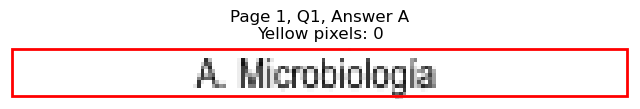

Page 1, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=116.9, y1=139.9
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 276
Page 1, Q1, B: Yellow percentage: 0.0%


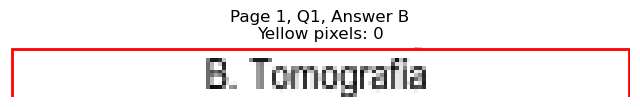

Page 1, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=368.7, y1=127.3
Page 1, Q1, C: Yellow pixels: 105
Page 1, Q1, C: Total non-white pixels: 360
Page 1, Q1, C: Yellow percentage: 29.2%


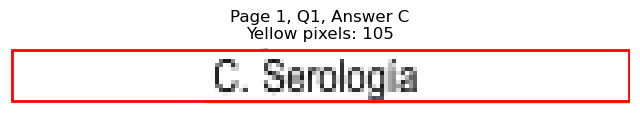

Page 1, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=376.7, y1=139.9
Page 1, Q1, D: Yellow pixels: 1215
Page 1, Q1, D: Total non-white pixels: 1482
Page 1, Q1, D: Yellow percentage: 82.0%


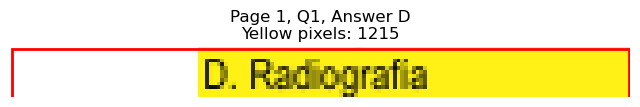


Page 1, Q1 - Selected Answer: D (based on yellow pixel count)
Page 1, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=99.9, y1=203.0
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 283
Page 1, Q2, A: Yellow percentage: 0.0%


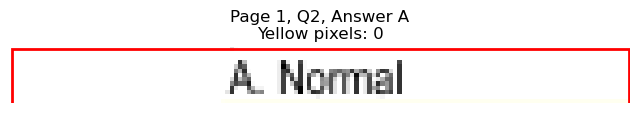

Page 1, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=116.4, y1=215.6
Page 1, Q2, B: Yellow pixels: 1235
Page 1, Q2, B: Total non-white pixels: 1568
Page 1, Q2, B: Yellow percentage: 78.8%


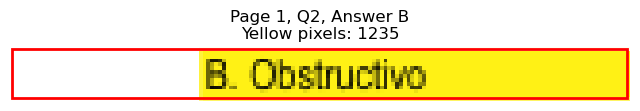

Page 1, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=372.2, y1=203.0
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 291
Page 1, Q2, C: Yellow percentage: 0.0%


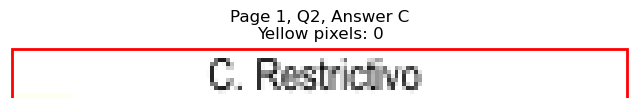

Page 1, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=351.7, y1=215.6
Page 1, Q2, D: Yellow pixels: 208
Page 1, Q2, D: Total non-white pixels: 404
Page 1, Q2, D: Yellow percentage: 51.5%


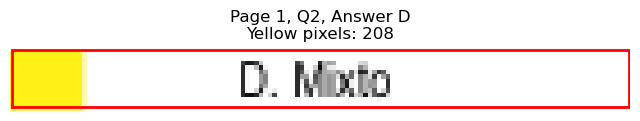


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)
Page 1, Q3 - A: Detected box: x0=56.6, y0=266.0, x1=99.4, y1=278.7
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 193
Page 1, Q3, A: Yellow percentage: 0.0%


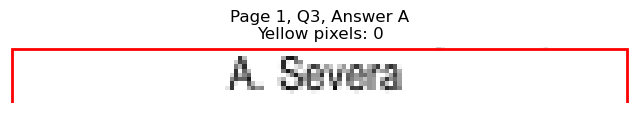

Page 1, Q3 - B: Detected box: x0=56.6, y0=278.8, x1=111.4, y1=291.4
Page 1, Q3, B: Yellow pixels: 1161
Page 1, Q3, B: Total non-white pixels: 1498
Page 1, Q3, B: Yellow percentage: 77.5%


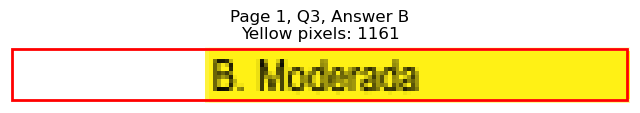

Page 1, Q3 - C: Detected box: x0=315.4, y0=266.0, x1=354.7, y1=278.7
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 158
Page 1, Q3, C: Yellow percentage: 0.0%


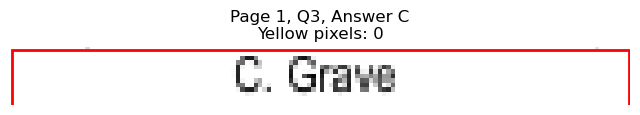

Page 1, Q3 - D: Detected box: x0=315.4, y0=278.8, x1=349.6, y1=291.4
Page 1, Q3, D: Yellow pixels: 208
Page 1, Q3, D: Total non-white pixels: 369
Page 1, Q3, D: Yellow percentage: 56.4%


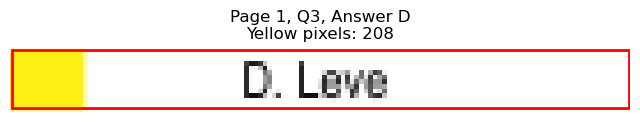


Page 1, Q3 - Selected Answer: B (based on yellow pixel count)
Page 1, Q4 - A: Detected box: x0=56.6, y0=341.9, x1=195.3, y1=354.6
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 670
Page 1, Q4, A: Yellow percentage: 0.0%


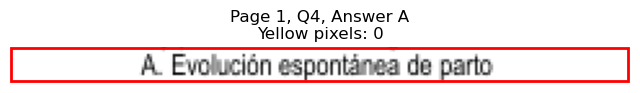

Page 1, Q4 - B: Detected box: x0=56.6, y0=354.5, x1=178.1, y1=367.2
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 568
Page 1, Q4, B: Yellow percentage: 0.0%


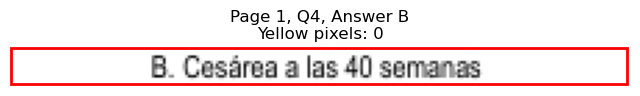

Page 1, Q4 - C: Detected box: x0=315.4, y0=341.9, x1=416.8, y1=354.6
Page 1, Q4, C: Yellow pixels: 1626
Page 1, Q4, C: Total non-white pixels: 2155
Page 1, Q4, C: Yellow percentage: 75.5%


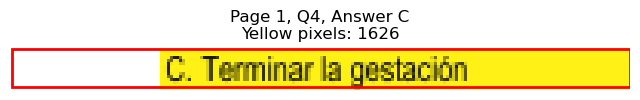

Page 1, Q4 - D: Detected box: x0=315.4, y0=354.5, x1=473.5, y1=367.2
Page 1, Q4, D: Yellow pixels: 208
Page 1, Q4, D: Total non-white pixels: 950
Page 1, Q4, D: Yellow percentage: 21.9%


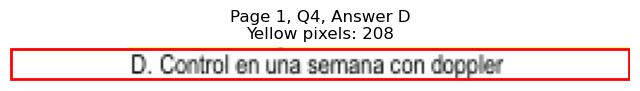


Page 1, Q4 - Selected Answer: C (based on yellow pixel count)
Page 1, Q5 - A: Detected box: x0=56.6, y0=404.9, x1=275.0, y1=417.6
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 1075
Page 1, Q5, A: Yellow percentage: 0.0%


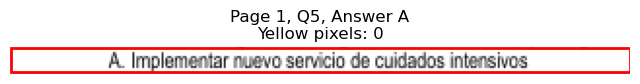

Page 1, Q5 - B: Detected box: x0=56.6, y0=417.6, x1=303.6, y1=430.3
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 1154
Page 1, Q5, B: Yellow percentage: 0.0%


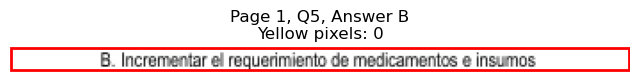

Page 1, Q5 - C: Detected box: x0=56.6, y0=430.2, x1=245.4, y1=442.9
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 1194
Page 1, Q5, C: Yellow percentage: 0.0%


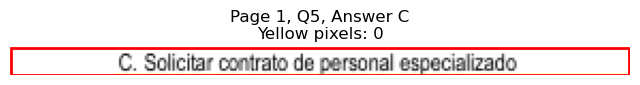

Page 1, Q5 - D: Detected box: x0=56.6, y0=442.8, x1=283.0, y1=455.5
Page 1, Q5, D: Yellow pixels: 2735
Page 1, Q5, D: Total non-white pixels: 3906
Page 1, Q5, D: Yellow percentage: 70.0%


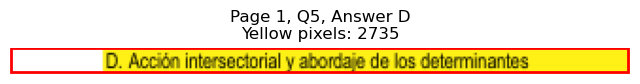


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)
Page 1, Q6 - A: Detected box: x0=56.6, y0=493.4, x1=200.8, y1=506.0
Page 1, Q6, A: Yellow pixels: 1991
Page 1, Q6, A: Total non-white pixels: 2556
Page 1, Q6, A: Yellow percentage: 77.9%


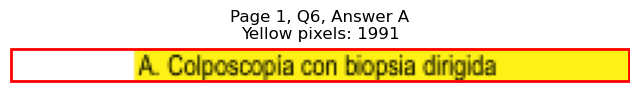

Page 1, Q6 - B: Detected box: x0=56.6, y0=506.0, x1=178.7, y1=518.6
Page 1, Q6, B: Yellow pixels: 165
Page 1, Q6, B: Total non-white pixels: 746
Page 1, Q6, B: Yellow percentage: 22.1%


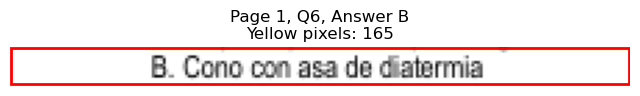

Page 1, Q6 - C: Detected box: x0=315.4, y0=493.4, x1=443.9, y1=506.0
Page 1, Q6, C: Yellow pixels: 208
Page 1, Q6, C: Total non-white pixels: 885
Page 1, Q6, C: Yellow percentage: 23.5%


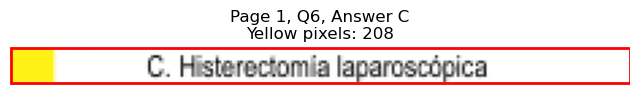

Page 1, Q6 - D: Detected box: x0=315.4, y0=506.0, x1=428.8, y1=518.6
Page 1, Q6, D: Yellow pixels: 16
Page 1, Q6, D: Total non-white pixels: 555
Page 1, Q6, D: Yellow percentage: 2.9%


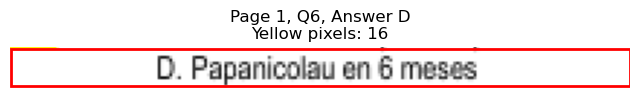


Page 1, Q6 - Selected Answer: A (based on yellow pixel count)
Page 1, Q7 - A: Detected box: x0=56.6, y0=569.1, x1=115.0, y1=581.7
Page 1, Q7, A: Yellow pixels: 1248
Page 1, Q7, A: Total non-white pixels: 1430
Page 1, Q7, A: Yellow percentage: 87.3%


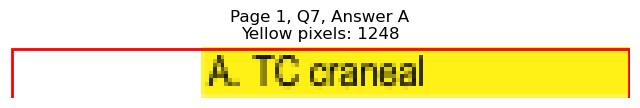

Page 1, Q7 - B: Detected box: x0=56.6, y0=581.7, x1=127.9, y1=594.3
Page 1, Q7, B: Yellow pixels: 123
Page 1, Q7, B: Total non-white pixels: 485
Page 1, Q7, B: Yellow percentage: 25.4%


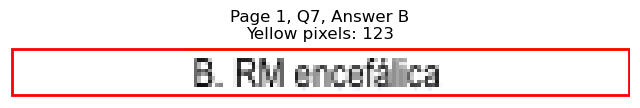

Page 1, Q7 - C: Detected box: x0=315.4, y0=569.1, x1=406.3, y1=581.7
Page 1, Q7, C: Yellow pixels: 208
Page 1, Q7, C: Total non-white pixels: 625
Page 1, Q7, C: Yellow percentage: 33.3%


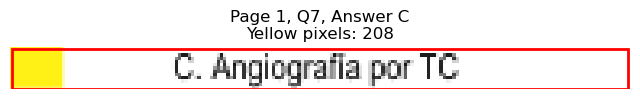

Page 1, Q7 - D: Detected box: x0=315.4, y0=581.7, x1=408.3, y1=594.3
Page 1, Q7, D: Yellow pixels: 16
Page 1, Q7, D: Total non-white pixels: 472
Page 1, Q7, D: Yellow percentage: 3.4%


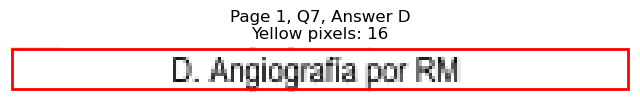


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)
Page 1, Q8 - A: Detected box: x0=56.6, y0=619.6, x1=103.9, y1=632.3
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 228
Page 1, Q8, A: Yellow percentage: 0.0%


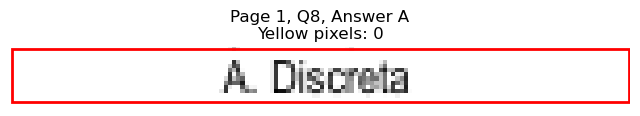

Page 1, Q8 - B: Detected box: x0=56.6, y0=632.2, x1=99.9, y1=644.9
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 179
Page 1, Q8, B: Yellow percentage: 0.0%


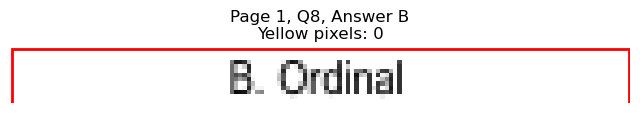

Page 1, Q8 - C: Detected box: x0=315.4, y0=619.6, x1=387.3, y1=632.3
Page 1, Q8, C: Yellow pixels: 1191
Page 1, Q8, C: Total non-white pixels: 1752
Page 1, Q8, C: Yellow percentage: 68.0%


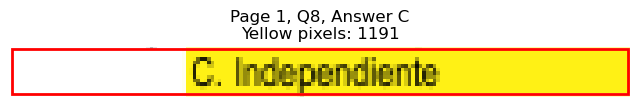

Page 1, Q8 - D: Detected box: x0=315.4, y0=632.2, x1=381.2, y1=644.9
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 445
Page 1, Q8, D: Yellow percentage: 0.0%


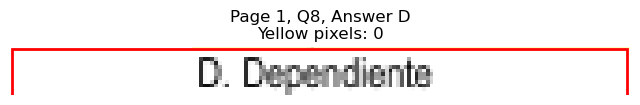


Page 1, Q8 - Selected Answer: C (based on yellow pixel count)
Page 1, Q9 - A: Detected box: x0=56.6, y0=695.4, x1=173.1, y1=708.0
Page 1, Q9, A: Yellow pixels: 169
Page 1, Q9, A: Total non-white pixels: 905
Page 1, Q9, A: Yellow percentage: 18.7%


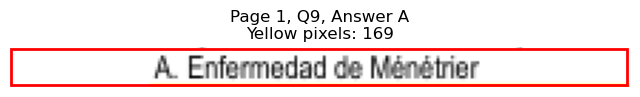

Page 1, Q9 - B: Detected box: x0=56.6, y0=708.0, x1=150.1, y1=720.6
Page 1, Q9, B: Yellow pixels: 1561
Page 1, Q9, B: Total non-white pixels: 2044
Page 1, Q9, B: Yellow percentage: 76.4%


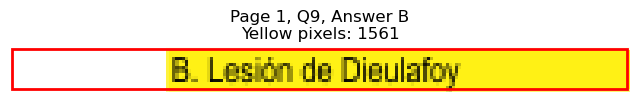

Page 1, Q9 - C: Detected box: x0=315.4, y0=695.4, x1=423.3, y1=708.0
Page 1, Q9, C: Yellow pixels: 16
Page 1, Q9, C: Total non-white pixels: 561
Page 1, Q9, C: Yellow percentage: 2.9%


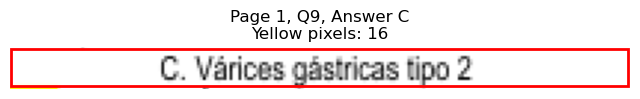

Page 1, Q9 - D: Detected box: x0=315.4, y0=708.0, x1=421.9, y1=720.6
Page 1, Q9, D: Yellow pixels: 208
Page 1, Q9, D: Total non-white pixels: 791
Page 1, Q9, D: Yellow percentage: 26.3%


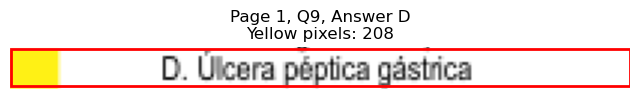


Page 1, Q9 - Selected Answer: B (based on yellow pixel count)

Page 2: Found 10 questions
Page 2, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=120.5, y1=127.3
Page 2, Q1, A: Yellow pixels: 116
Page 2, Q1, A: Total non-white pixels: 416
Page 2, Q1, A: Yellow percentage: 27.9%


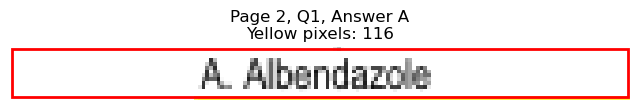

Page 2, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=117.5, y1=139.9
Page 2, Q1, B: Yellow pixels: 1235
Page 2, Q1, B: Total non-white pixels: 1469
Page 2, Q1, B: Yellow percentage: 84.1%


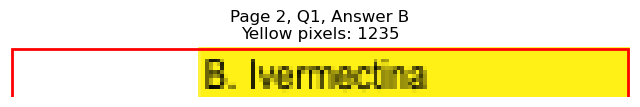

Page 2, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=410.8, y1=127.3
Page 2, Q1, C: Yellow pixels: 16
Page 2, Q1, C: Total non-white pixels: 472
Page 2, Q1, C: Yellow percentage: 3.4%


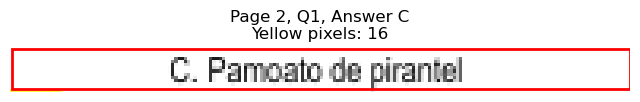

Page 2, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=379.3, y1=139.9
Page 2, Q1, D: Yellow pixels: 208
Page 2, Q1, D: Total non-white pixels: 540
Page 2, Q1, D: Yellow percentage: 38.5%


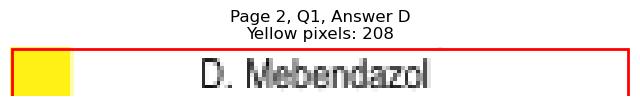


Page 2, Q1 - Selected Answer: B (based on yellow pixel count)
Page 2, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=158.2, y1=177.8
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 481
Page 2, Q2, A: Yellow percentage: 0.0%


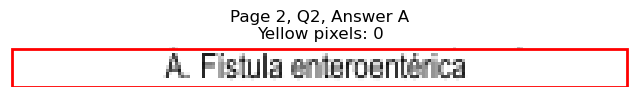

Page 2, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=145.0, y1=190.4
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 424
Page 2, Q2, B: Yellow percentage: 0.0%


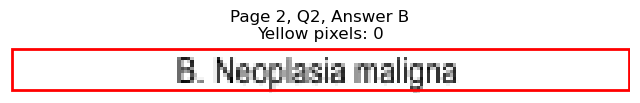

Page 2, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=400.3, y1=177.8
Page 2, Q2, C: Yellow pixels: 1465
Page 2, Q2, C: Total non-white pixels: 1794
Page 2, Q2, C: Yellow percentage: 81.7%


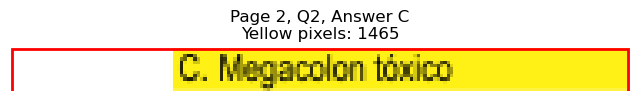

Page 2, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=389.8, y1=190.4
Page 2, Q2, D: Yellow pixels: 125
Page 2, Q2, D: Total non-white pixels: 494
Page 2, Q2, D: Yellow percentage: 25.3%


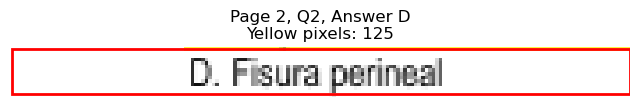


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)
Page 2, Q3 - A: Detected box: x0=56.6, y0=228.2, x1=80.9, y1=240.9
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 171
Page 2, Q3, A: Yellow percentage: 0.0%


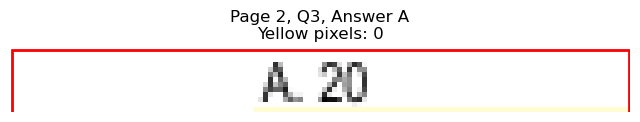

Page 2, Q3 - B: Detected box: x0=56.6, y0=240.8, x1=80.9, y1=253.5
Page 2, Q3, B: Yellow pixels: 904
Page 2, Q3, B: Total non-white pixels: 1064
Page 2, Q3, B: Yellow percentage: 85.0%


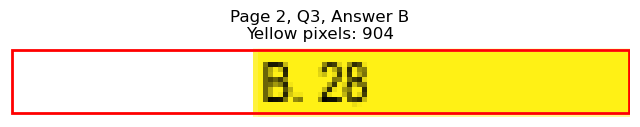

Page 2, Q3 - C: Detected box: x0=315.4, y0=228.2, x1=340.1, y1=240.9
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 108
Page 2, Q3, C: Yellow percentage: 0.0%


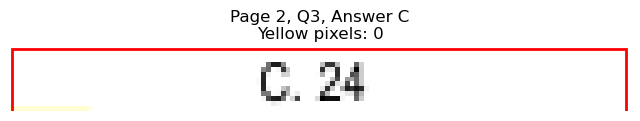

Page 2, Q3 - D: Detected box: x0=315.4, y0=240.8, x1=340.1, y1=253.5
Page 2, Q3, D: Yellow pixels: 208
Page 2, Q3, D: Total non-white pixels: 334
Page 2, Q3, D: Yellow percentage: 62.3%


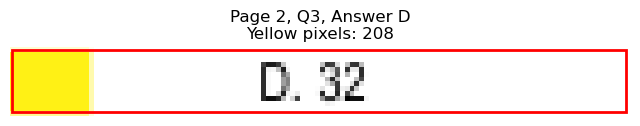


Page 2, Q3 - Selected Answer: B (based on yellow pixel count)
Page 2, Q4 - A: Detected box: x0=56.6, y0=304.0, x1=189.6, y1=316.6
Page 2, Q4, A: Yellow pixels: 1891
Page 2, Q4, A: Total non-white pixels: 2416
Page 2, Q4, A: Yellow percentage: 78.3%


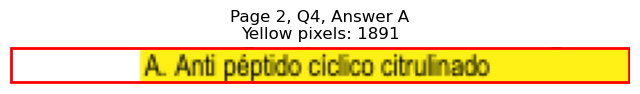

Page 2, Q4 - B: Detected box: x0=56.6, y0=316.6, x1=149.1, y1=329.2
Page 2, Q4, B: Yellow pixels: 145
Page 2, Q4, B: Total non-white pixels: 571
Page 2, Q4, B: Yellow percentage: 25.4%


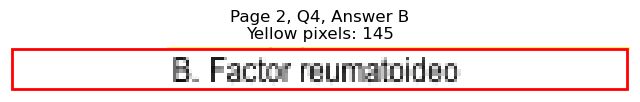

Page 2, Q4 - C: Detected box: x0=315.4, y0=304.0, x1=407.3, y1=316.6
Page 2, Q4, C: Yellow pixels: 208
Page 2, Q4, C: Total non-white pixels: 665
Page 2, Q4, C: Yellow percentage: 31.3%


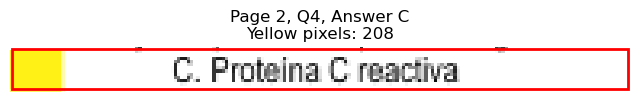

Page 2, Q4 - D: Detected box: x0=315.4, y0=316.6, x1=418.9, y1=329.2
Page 2, Q4, D: Yellow pixels: 16
Page 2, Q4, D: Total non-white pixels: 531
Page 2, Q4, D: Yellow percentage: 3.0%


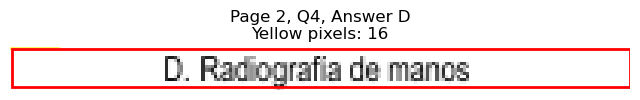


Page 2, Q4 - Selected Answer: A (based on yellow pixel count)
Page 2, Q5 - A: Detected box: x0=56.6, y0=354.5, x1=138.5, y1=367.2
Page 2, Q5, A: Yellow pixels: 1439
Page 2, Q5, A: Total non-white pixels: 1876
Page 2, Q5, A: Yellow percentage: 76.7%


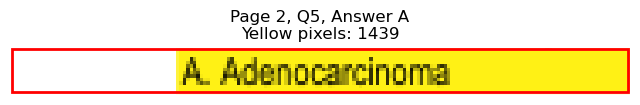

Page 2, Q5 - B: Detected box: x0=56.6, y0=367.1, x1=137.1, y1=379.8
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 514
Page 2, Q5, B: Yellow percentage: 0.0%


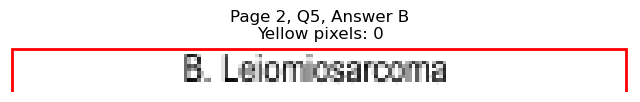

Page 2, Q5 - C: Detected box: x0=315.4, y0=354.5, x1=362.2, y1=367.2
Page 2, Q5, C: Yellow pixels: 208
Page 2, Q5, C: Total non-white pixels: 425
Page 2, Q5, C: Yellow percentage: 48.9%


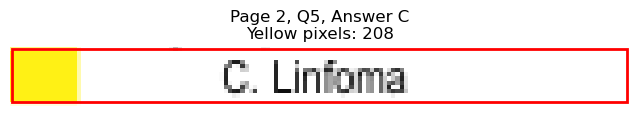

Page 2, Q5 - D: Detected box: x0=315.4, y0=367.1, x1=394.3, y1=379.8
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 398
Page 2, Q5, D: Yellow percentage: 0.0%


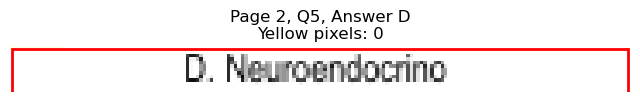


Page 2, Q5 - Selected Answer: A (based on yellow pixel count)
Page 2, Q6 - A: Detected box: x0=56.6, y0=430.2, x1=141.0, y1=442.9
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 566
Page 2, Q6, A: Yellow percentage: 0.0%


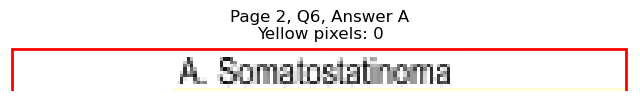

Page 2, Q6 - B: Detected box: x0=56.6, y0=442.8, x1=114.5, y1=455.5
Page 2, Q6, B: Yellow pixels: 1236
Page 2, Q6, B: Total non-white pixels: 1540
Page 2, Q6, B: Yellow percentage: 80.3%


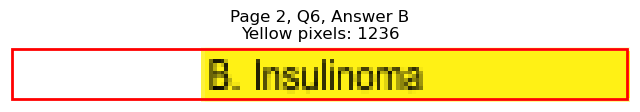

Page 2, Q6 - C: Detected box: x0=315.4, y0=430.2, x1=376.7, y1=442.9
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 291
Page 2, Q6, C: Yellow percentage: 0.0%


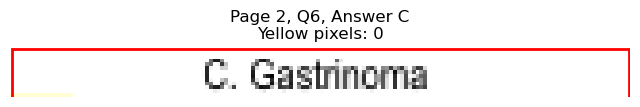

Page 2, Q6 - D: Detected box: x0=315.4, y0=442.8, x1=386.2, y1=455.5
Page 2, Q6, D: Yellow pixels: 208
Page 2, Q6, D: Total non-white pixels: 564
Page 2, Q6, D: Yellow percentage: 36.9%


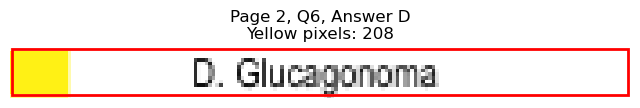


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)
Page 2, Q7 - A: Detected box: x0=56.6, y0=480.8, x1=150.0, y1=493.4
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 456
Page 2, Q7, A: Yellow percentage: 0.0%


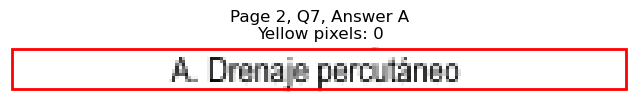

Page 2, Q7 - B: Detected box: x0=56.6, y0=493.4, x1=120.5, y1=506.0
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 336
Page 2, Q7, B: Yellow percentage: 0.0%


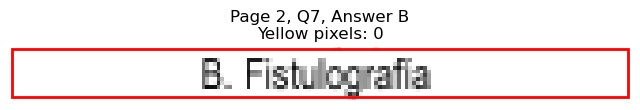

Page 2, Q7 - C: Detected box: x0=315.4, y0=480.8, x1=380.7, y1=493.4
Page 2, Q7, C: Yellow pixels: 1179
Page 2, Q7, C: Total non-white pixels: 1655
Page 2, Q7, C: Yellow percentage: 71.2%


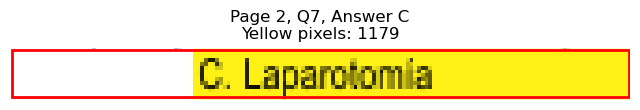

Page 2, Q7 - D: Detected box: x0=315.4, y0=493.4, x1=380.7, y1=506.0
Page 2, Q7, D: Yellow pixels: 1
Page 2, Q7, D: Total non-white pixels: 421
Page 2, Q7, D: Yellow percentage: 0.2%


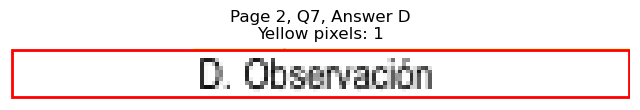


Page 2, Q7 - Selected Answer: C (based on yellow pixel count)
Page 2, Q8 - A: Detected box: x0=56.6, y0=543.8, x1=108.4, y1=556.4
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 245
Page 2, Q8, A: Yellow percentage: 0.0%


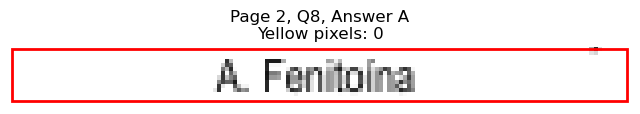

Page 2, Q8 - B: Detected box: x0=56.6, y0=556.5, x1=102.9, y1=569.1
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 220
Page 2, Q8, B: Yellow percentage: 0.0%


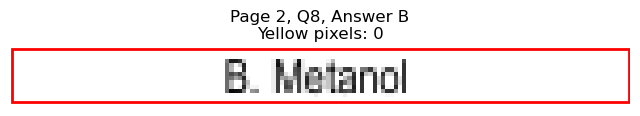

Page 2, Q8 - C: Detected box: x0=315.4, y0=543.8, x1=370.6, y1=556.4
Page 2, Q8, C: Yellow pixels: 1195
Page 2, Q8, C: Total non-white pixels: 1511
Page 2, Q8, C: Yellow percentage: 79.1%


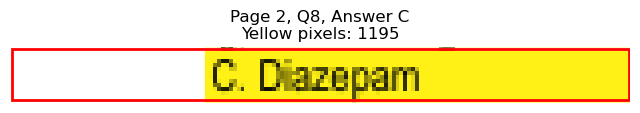

Page 2, Q8 - D: Detected box: x0=315.4, y0=556.5, x1=368.7, y1=569.1
Page 2, Q8, D: Yellow pixels: 105
Page 2, Q8, D: Total non-white pixels: 341
Page 2, Q8, D: Yellow percentage: 30.8%


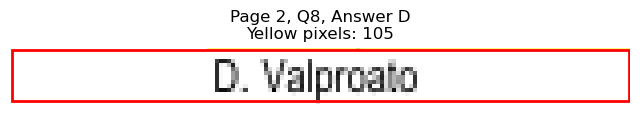


Page 2, Q8 - Selected Answer: C (based on yellow pixel count)
Page 2, Q9 - A: Detected box: x0=56.6, y0=619.6, x1=135.0, y1=632.3
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 398
Page 2, Q9, A: Yellow percentage: 0.0%


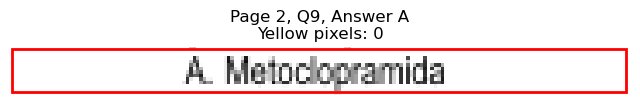

Page 2, Q9 - B: Detected box: x0=56.6, y0=632.2, x1=111.4, y1=644.9
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 273
Page 2, Q9, B: Yellow percentage: 0.0%


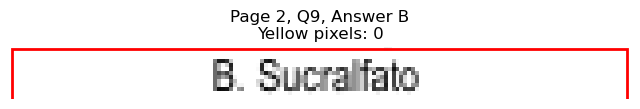

Page 2, Q9 - C: Detected box: x0=315.4, y0=619.6, x1=371.7, y1=632.3
Page 2, Q9, C: Yellow pixels: 1089
Page 2, Q9, C: Total non-white pixels: 1525
Page 2, Q9, C: Yellow percentage: 71.4%


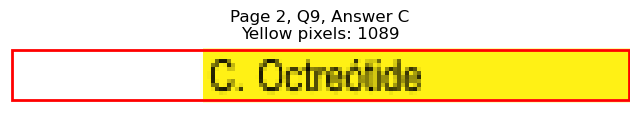

Page 2, Q9 - D: Detected box: x0=315.4, y0=632.2, x1=370.1, y1=644.9
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 387
Page 2, Q9, D: Yellow percentage: 0.0%


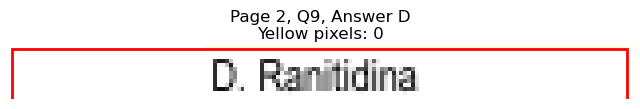


Page 2, Q9 - Selected Answer: C (based on yellow pixel count)
Page 2, Q10 - A: Detected box: x0=56.6, y0=682.6, x1=74.8, y1=695.3
Page 2, Q10, A: Yellow pixels: 730
Page 2, Q10, A: Total non-white pixels: 980
Page 2, Q10, A: Yellow percentage: 74.5%


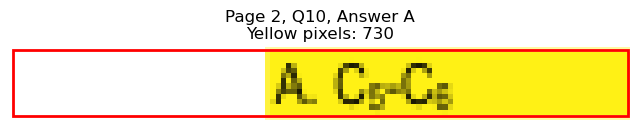

Page 2, Q10 - B: Detected box: x0=56.6, y0=695.4, x1=74.8, y1=708.0
Page 2, Q10, B: Yellow pixels: 0
Page 2, Q10, B: Total non-white pixels: 210
Page 2, Q10, B: Yellow percentage: 0.0%


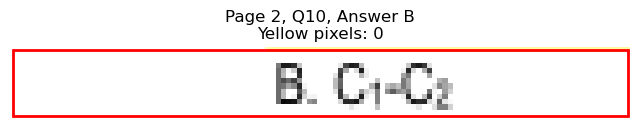

Page 2, Q10 - C: Detected box: x0=315.4, y0=682.6, x1=334.1, y1=695.3
Page 2, Q10, C: Yellow pixels: 193
Page 2, Q10, C: Total non-white pixels: 373
Page 2, Q10, C: Yellow percentage: 51.7%


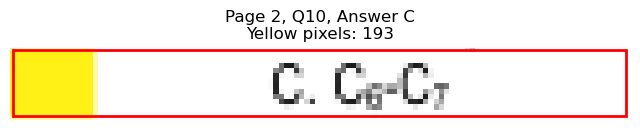

Page 2, Q10 - D: Detected box: x0=315.4, y0=695.4, x1=334.1, y1=708.0
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 161
Page 2, Q10, D: Yellow percentage: 0.0%


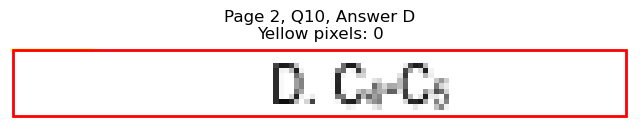


Page 2, Q10 - Selected Answer: A (based on yellow pixel count)

Page 3: Found 9 questions
Page 3, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=141.5, y1=127.3
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 420
Page 3, Q1, A: Yellow percentage: 0.0%


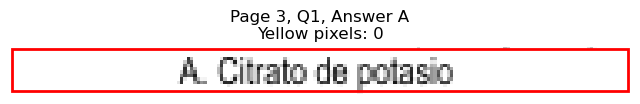

Page 3, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=153.0, y1=139.9
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 484
Page 3, Q1, B: Yellow percentage: 0.0%


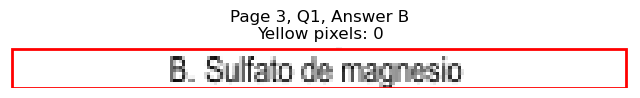

Page 3, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=414.8, y1=127.3
Page 3, Q1, C: Yellow pixels: 151
Page 3, Q1, C: Total non-white pixels: 620
Page 3, Q1, C: Yellow percentage: 24.4%


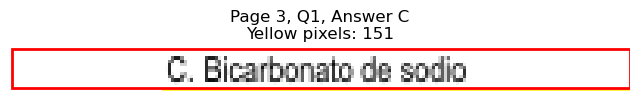

Page 3, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=409.3, y1=139.9
Page 3, Q1, D: Yellow pixels: 1573
Page 3, Q1, D: Total non-white pixels: 1911
Page 3, Q1, D: Yellow percentage: 82.3%


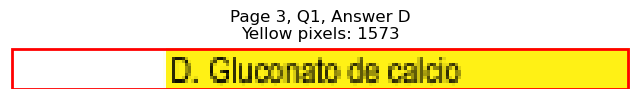


Page 3, Q1 - Selected Answer: D (based on yellow pixel count)
Page 3, Q2 - A: Detected box: x0=56.6, y0=202.9, x1=133.9, y1=215.6
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 386
Page 3, Q2, A: Yellow percentage: 0.0%


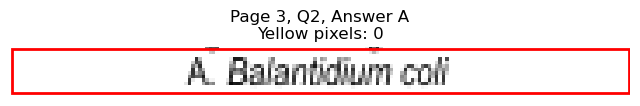

Page 3, Q2 - B: Detected box: x0=56.6, y0=215.6, x1=142.5, y1=228.3
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 425
Page 3, Q2, B: Yellow percentage: 0.0%


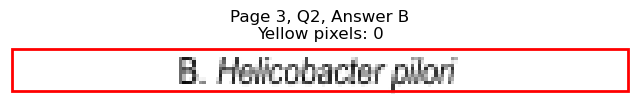

Page 3, Q2 - C: Detected box: x0=315.4, y0=202.9, x1=390.2, y1=215.6
Page 3, Q2, C: Yellow pixels: 1363
Page 3, Q2, C: Total non-white pixels: 1791
Page 3, Q2, C: Yellow percentage: 76.1%


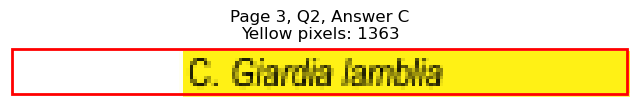

Page 3, Q2 - D: Detected box: x0=315.4, y0=215.6, x1=402.8, y1=228.3
Page 3, Q2, D: Yellow pixels: 139
Page 3, Q2, D: Total non-white pixels: 563
Page 3, Q2, D: Yellow percentage: 24.7%


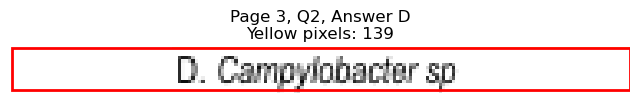


Page 3, Q2 - Selected Answer: C (based on yellow pixel count)
Page 3, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=109.9, y1=266.1
Page 3, Q3, A: Yellow pixels: 1203
Page 3, Q3, A: Total non-white pixels: 1470
Page 3, Q3, A: Yellow percentage: 81.8%


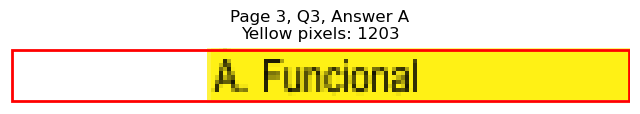

Page 3, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=110.9, y1=278.7
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 351
Page 3, Q3, B: Yellow percentage: 0.0%


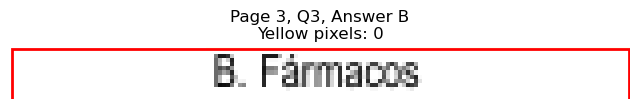

Page 3, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=428.3, y1=266.1
Page 3, Q3, C: Yellow pixels: 208
Page 3, Q3, C: Total non-white pixels: 789
Page 3, Q3, C: Yellow percentage: 26.4%


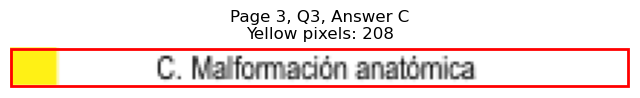

Page 3, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=366.7, y1=278.7
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 255
Page 3, Q3, D: Yellow percentage: 0.0%


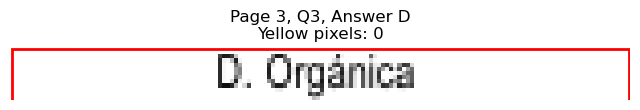


Page 3, Q3 - Selected Answer: A (based on yellow pixel count)
Page 3, Q4 - A: Detected box: x0=56.6, y0=329.2, x1=132.0, y1=341.8
Page 3, Q4, A: Yellow pixels: 1419
Page 3, Q4, A: Total non-white pixels: 1664
Page 3, Q4, A: Yellow percentage: 85.3%


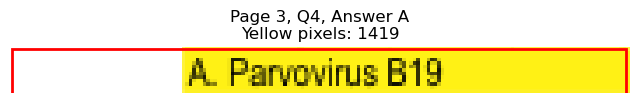

Page 3, Q4 - B: Detected box: x0=56.6, y0=341.9, x1=127.9, y1=354.6
Page 3, Q4, B: Yellow pixels: 123
Page 3, Q4, B: Total non-white pixels: 469
Page 3, Q4, B: Yellow percentage: 26.2%


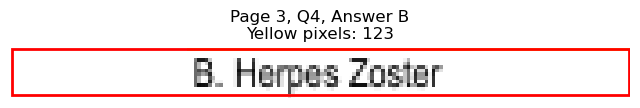

Page 3, Q4 - C: Detected box: x0=315.4, y0=329.2, x1=388.3, y1=341.8
Page 3, Q4, C: Yellow pixels: 208
Page 3, Q4, C: Total non-white pixels: 550
Page 3, Q4, C: Yellow percentage: 37.8%


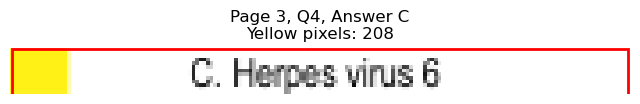

Page 3, Q4 - D: Detected box: x0=315.4, y0=341.9, x1=387.2, y1=354.6
Page 3, Q4, D: Yellow pixels: 16
Page 3, Q4, D: Total non-white pixels: 348
Page 3, Q4, D: Yellow percentage: 4.6%


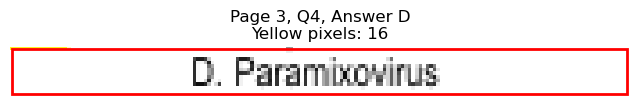


Page 3, Q4 - Selected Answer: A (based on yellow pixel count)
Page 3, Q5 - A: Detected box: x0=56.6, y0=404.9, x1=204.2, y1=417.6
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 676
Page 3, Q5, A: Yellow percentage: 0.0%


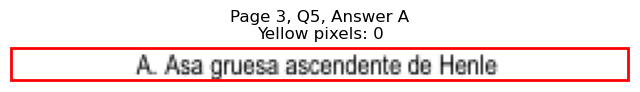

Page 3, Q5 - B: Detected box: x0=56.6, y0=417.6, x1=110.4, y1=430.3
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 268
Page 3, Q5, B: Yellow percentage: 0.0%


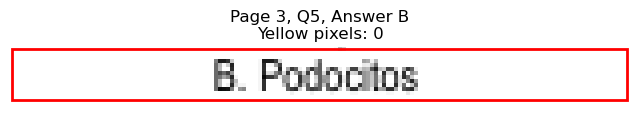

Page 3, Q5 - C: Detected box: x0=315.4, y0=404.9, x1=442.4, y1=417.6
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 638
Page 3, Q5, C: Yellow percentage: 0.0%


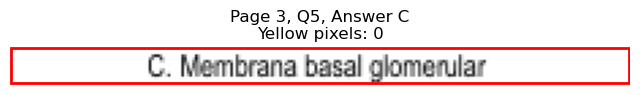

Page 3, Q5 - D: Detected box: x0=315.4, y0=417.6, x1=391.7, y1=430.3
Page 3, Q5, D: Yellow pixels: 1245
Page 3, Q5, D: Total non-white pixels: 1805
Page 3, Q5, D: Yellow percentage: 69.0%


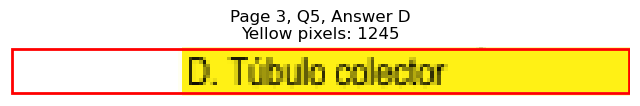


Page 3, Q5 - Selected Answer: D (based on yellow pixel count)
Page 3, Q6 - A: Detected box: x0=56.6, y0=493.4, x1=143.5, y1=506.0
Page 3, Q6, A: Yellow pixels: 139
Page 3, Q6, A: Total non-white pixels: 680
Page 3, Q6, A: Yellow percentage: 20.4%


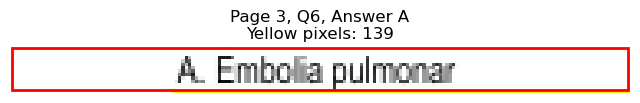

Page 3, Q6 - B: Detected box: x0=56.6, y0=506.0, x1=134.5, y1=518.6
Page 3, Q6, B: Yellow pixels: 1383
Page 3, Q6, B: Total non-white pixels: 1820
Page 3, Q6, B: Yellow percentage: 76.0%


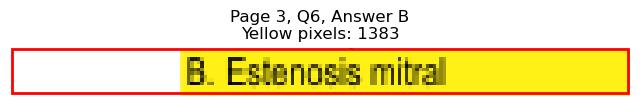

Page 3, Q6 - C: Detected box: x0=315.4, y0=493.4, x1=414.8, y1=506.0
Page 3, Q6, C: Yellow pixels: 16
Page 3, Q6, C: Total non-white pixels: 502
Page 3, Q6, C: Yellow percentage: 3.2%


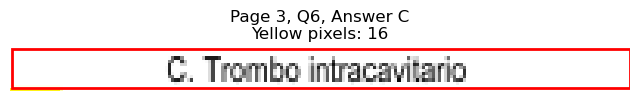

Page 3, Q6 - D: Detected box: x0=315.4, y0=506.0, x1=392.2, y1=518.6
Page 3, Q6, D: Yellow pixels: 208
Page 3, Q6, D: Total non-white pixels: 628
Page 3, Q6, D: Yellow percentage: 33.1%


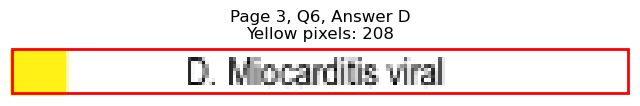


Page 3, Q6 - Selected Answer: B (based on yellow pixel count)
Page 3, Q7 - A: Detected box: x0=56.6, y0=543.8, x1=157.6, y1=556.4
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 484
Page 3, Q7, A: Yellow percentage: 0.0%


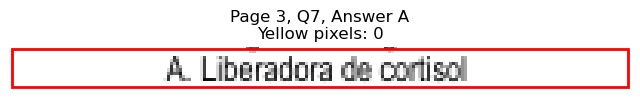

Page 3, Q7 - B: Detected box: x0=56.6, y0=556.5, x1=204.2, y1=569.1
Page 3, Q7, B: Yellow pixels: 2024
Page 3, Q7, B: Total non-white pixels: 2800
Page 3, Q7, B: Yellow percentage: 72.3%


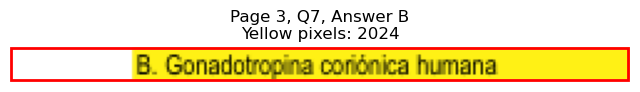

Page 3, Q7 - C: Detected box: x0=315.4, y0=543.8, x1=390.2, y1=556.4
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 347
Page 3, Q7, C: Yellow percentage: 0.0%


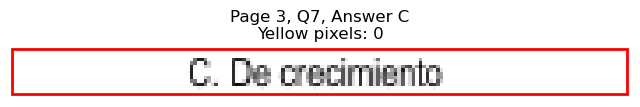

Page 3, Q7 - D: Detected box: x0=315.4, y0=556.5, x1=379.7, y1=569.1
Page 3, Q7, D: Yellow pixels: 208
Page 3, Q7, D: Total non-white pixels: 555
Page 3, Q7, D: Yellow percentage: 37.5%


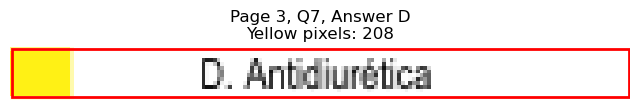


Page 3, Q7 - Selected Answer: B (based on yellow pixel count)
Page 3, Q8 - A: Detected box: x0=56.6, y0=632.2, x1=134.5, y1=644.9
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 507
Page 3, Q8, A: Yellow percentage: 0.0%


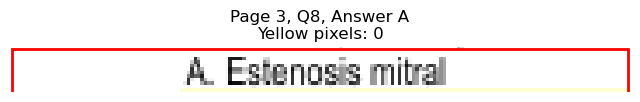

Page 3, Q8 - B: Detected box: x0=56.6, y0=644.8, x1=150.0, y1=657.5
Page 3, Q8, B: Yellow pixels: 1558
Page 3, Q8, B: Total non-white pixels: 2044
Page 3, Q8, B: Yellow percentage: 76.2%


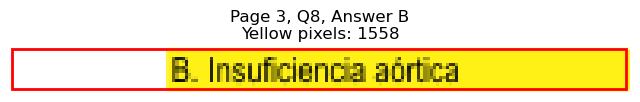

Page 3, Q8 - C: Detected box: x0=315.4, y0=632.2, x1=398.8, y1=644.9
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 411
Page 3, Q8, C: Yellow percentage: 0.0%


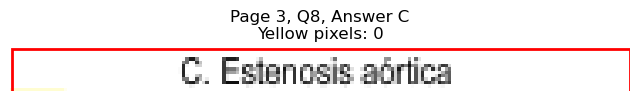

Page 3, Q8 - D: Detected box: x0=315.4, y0=644.8, x1=404.2, y1=657.5
Page 3, Q8, D: Yellow pixels: 208
Page 3, Q8, D: Total non-white pixels: 678
Page 3, Q8, D: Yellow percentage: 30.7%


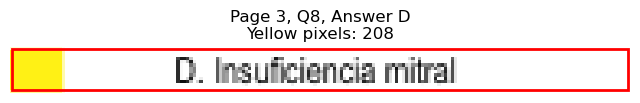


Page 3, Q8 - Selected Answer: B (based on yellow pixel count)
Page 3, Q9 - A: Detected box: x0=56.6, y0=708.0, x1=108.9, y1=720.6
Page 3, Q9, A: Yellow pixels: 103
Page 3, Q9, A: Total non-white pixels: 333
Page 3, Q9, A: Yellow percentage: 30.9%


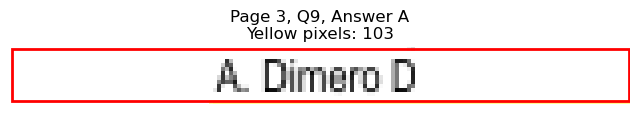

Page 3, Q9 - B: Detected box: x0=56.6, y0=720.6, x1=205.2, y1=733.2
Page 3, Q9, B: Yellow pixels: 2034
Page 3, Q9, B: Total non-white pixels: 2814
Page 3, Q9, B: Yellow percentage: 72.3%


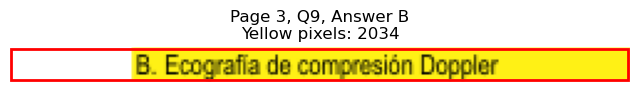

Page 3, Q9 - C: Detected box: x0=315.4, y0=708.0, x1=430.9, y1=720.6
Page 3, Q9, C: Yellow pixels: 16
Page 3, Q9, C: Total non-white pixels: 586
Page 3, Q9, C: Yellow percentage: 2.7%


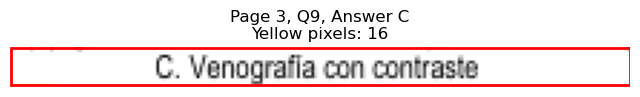

Page 3, Q9 - D: Detected box: x0=315.4, y0=720.6, x1=396.3, y1=733.2
Page 3, Q9, D: Yellow pixels: 208
Page 3, Q9, D: Total non-white pixels: 632
Page 3, Q9, D: Yellow percentage: 32.9%


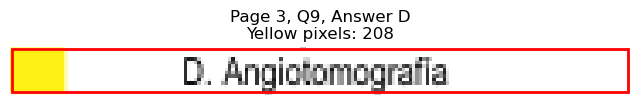


Page 3, Q9 - Selected Answer: B (based on yellow pixel count)

Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=127.9, y1=114.7
Page 4, Q1, A: Yellow pixels: 1
Page 4, Q1, A: Total non-white pixels: 455
Page 4, Q1, A: Yellow percentage: 0.2%


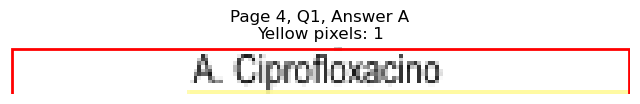

Page 4, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=158.1, y1=127.3
Page 4, Q1, B: Yellow pixels: 1431
Page 4, Q1, B: Total non-white pixels: 2156
Page 4, Q1, B: Yellow percentage: 66.4%


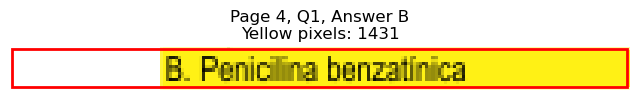

Page 4, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=376.1, y1=114.7
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 305
Page 4, Q1, C: Yellow percentage: 0.0%


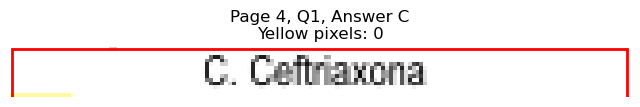

Page 4, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=375.7, y1=127.3
Page 4, Q1, D: Yellow pixels: 192
Page 4, Q1, D: Total non-white pixels: 520
Page 4, Q1, D: Yellow percentage: 36.9%


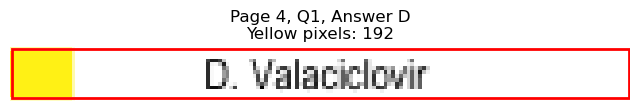


Page 4, Q1 - Selected Answer: B (based on yellow pixel count)
Page 4, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=88.3, y1=177.8
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 219
Page 4, Q2, A: Yellow percentage: 0.0%


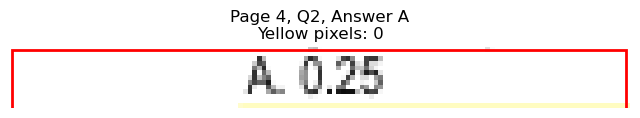

Page 4, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=83.4, y1=190.4
Page 4, Q2, B: Yellow pixels: 866
Page 4, Q2, B: Total non-white pixels: 1106
Page 4, Q2, B: Yellow percentage: 78.3%


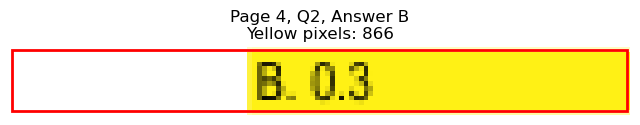

Page 4, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=342.7, y1=177.8
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 117
Page 4, Q2, C: Yellow percentage: 0.0%


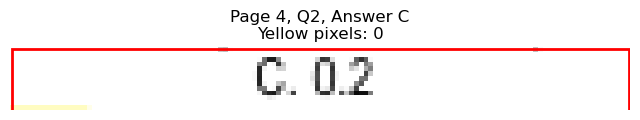

Page 4, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=347.6, y1=190.4
Page 4, Q2, D: Yellow pixels: 192
Page 4, Q2, D: Total non-white pixels: 364
Page 4, Q2, D: Yellow percentage: 52.7%


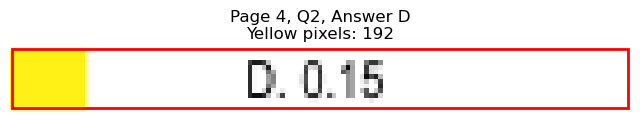


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)
Page 4, Q3 - A: Detected box: x0=56.6, y0=228.2, x1=121.5, y1=240.9
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 313
Page 4, Q3, A: Yellow percentage: 0.0%


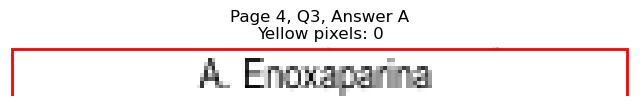

Page 4, Q3 - B: Detected box: x0=56.6, y0=240.8, x1=109.9, y1=253.5
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 242
Page 4, Q3, B: Yellow percentage: 0.0%


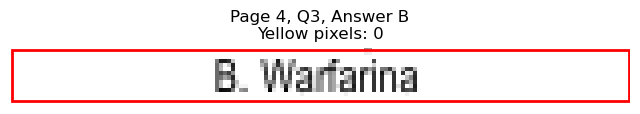

Page 4, Q3 - C: Detected box: x0=315.4, y0=228.2, x1=428.3, y1=240.9
Page 4, Q3, C: Yellow pixels: 1740
Page 4, Q3, C: Total non-white pixels: 2158
Page 4, Q3, C: Yellow percentage: 80.6%


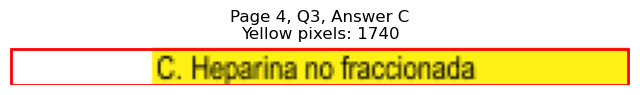

Page 4, Q3 - D: Detected box: x0=315.4, y0=240.8, x1=373.7, y1=253.5
Page 4, Q3, D: Yellow pixels: 108
Page 4, Q3, D: Total non-white pixels: 375
Page 4, Q3, D: Yellow percentage: 28.8%


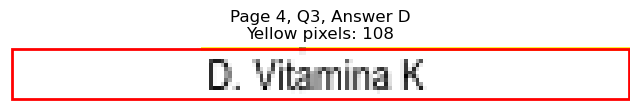


Page 4, Q3 - Selected Answer: C (based on yellow pixel count)
Page 4, Q4 - A: Detected box: x0=56.6, y0=304.0, x1=112.9, y1=316.6
Page 4, Q4, A: Yellow pixels: 1193
Page 4, Q4, A: Total non-white pixels: 1412
Page 4, Q4, A: Yellow percentage: 84.5%


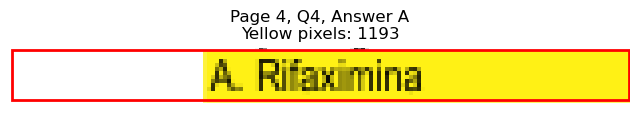

Page 4, Q4 - B: Detected box: x0=56.6, y0=316.6, x1=119.9, y1=329.2
Page 4, Q4, B: Yellow pixels: 115
Page 4, Q4, B: Total non-white pixels: 405
Page 4, Q4, B: Yellow percentage: 28.4%


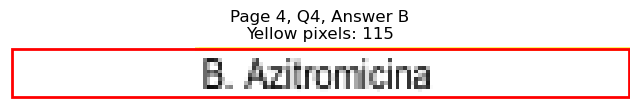

Page 4, Q4 - C: Detected box: x0=315.4, y0=304.0, x1=387.2, y1=316.6
Page 4, Q4, C: Yellow pixels: 208
Page 4, Q4, C: Total non-white pixels: 573
Page 4, Q4, C: Yellow percentage: 36.3%


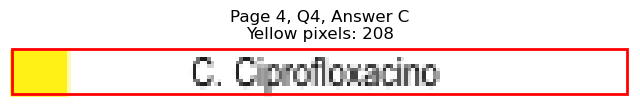

Page 4, Q4 - D: Detected box: x0=315.4, y0=316.6, x1=375.7, y1=329.2
Page 4, Q4, D: Yellow pixels: 16
Page 4, Q4, D: Total non-white pixels: 312
Page 4, Q4, D: Yellow percentage: 5.1%


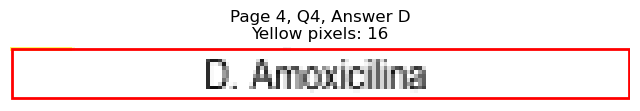


Page 4, Q4 - Selected Answer: A (based on yellow pixel count)
Page 4, Q5 - A: Detected box: x0=56.6, y0=367.1, x1=163.6, y1=379.8
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 544
Page 4, Q5, A: Yellow percentage: 0.0%


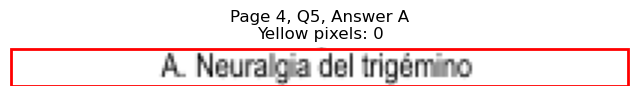

Page 4, Q5 - B: Detected box: x0=56.6, y0=379.7, x1=103.5, y1=392.4
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 258
Page 4, Q5, B: Yellow percentage: 0.0%


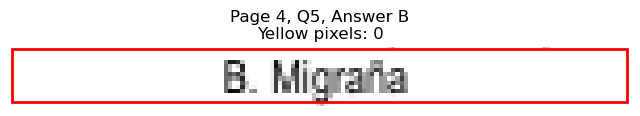

Page 4, Q5 - C: Detected box: x0=315.4, y0=367.1, x1=399.8, y1=379.8
Page 4, Q5, C: Yellow pixels: 1453
Page 4, Q5, C: Total non-white pixels: 1781
Page 4, Q5, C: Yellow percentage: 81.6%


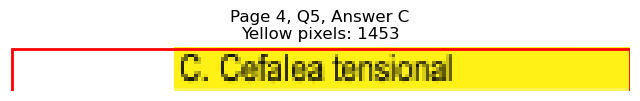

Page 4, Q5 - D: Detected box: x0=315.4, y0=379.7, x1=407.8, y1=392.4
Page 4, Q5, D: Yellow pixels: 144
Page 4, Q5, D: Total non-white pixels: 573
Page 4, Q5, D: Yellow percentage: 25.1%


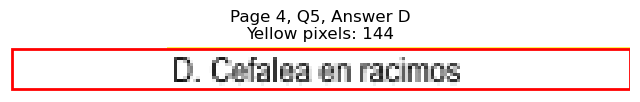


Page 4, Q5 - Selected Answer: C (based on yellow pixel count)
Page 4, Q6 - A: Detected box: x0=56.6, y0=430.2, x1=113.9, y1=442.9
Page 4, Q6, A: Yellow pixels: 1216
Page 4, Q6, A: Total non-white pixels: 1417
Page 4, Q6, A: Yellow percentage: 85.8%


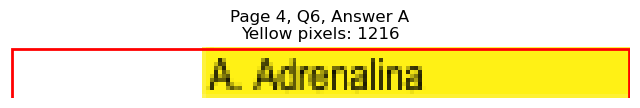

Page 4, Q6 - B: Detected box: x0=56.6, y0=442.8, x1=123.5, y1=455.5
Page 4, Q6, B: Yellow pixels: 119
Page 4, Q6, B: Total non-white pixels: 440
Page 4, Q6, B: Yellow percentage: 27.0%


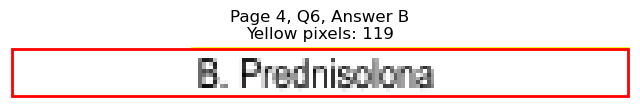

Page 4, Q6 - C: Detected box: x0=315.4, y0=430.2, x1=367.6, y1=442.9
Page 4, Q6, C: Yellow pixels: 208
Page 4, Q6, C: Total non-white pixels: 452
Page 4, Q6, C: Yellow percentage: 46.0%


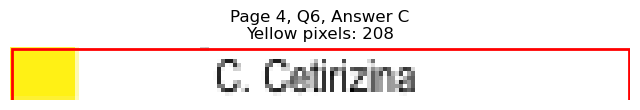

Page 4, Q6 - D: Detected box: x0=315.4, y0=442.8, x1=383.7, y1=455.5
Page 4, Q6, D: Yellow pixels: 16
Page 4, Q6, D: Total non-white pixels: 351
Page 4, Q6, D: Yellow percentage: 4.6%


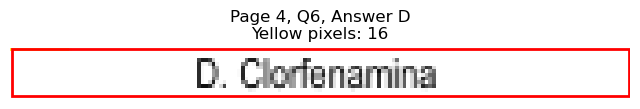


Page 4, Q6 - Selected Answer: A (based on yellow pixel count)
Page 4, Q7 - A: Detected box: x0=56.6, y0=506.0, x1=167.1, y1=518.6
Page 4, Q7, A: Yellow pixels: 1699
Page 4, Q7, A: Total non-white pixels: 2282
Page 4, Q7, A: Yellow percentage: 74.5%


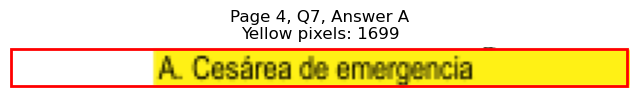

Page 4, Q7 - B: Detected box: x0=56.6, y0=518.6, x1=131.5, y1=531.2
Page 4, Q7, B: Yellow pixels: 126
Page 4, Q7, B: Total non-white pixels: 473
Page 4, Q7, B: Yellow percentage: 26.6%


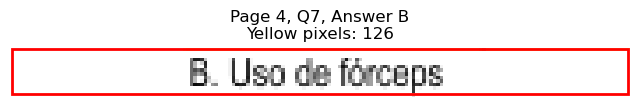

Page 4, Q7 - C: Detected box: x0=315.4, y0=506.0, x1=410.8, y1=518.6
Page 4, Q7, C: Yellow pixels: 208
Page 4, Q7, C: Total non-white pixels: 712
Page 4, Q7, C: Yellow percentage: 29.2%


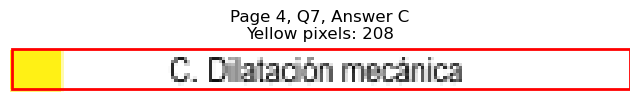

Page 4, Q7 - D: Detected box: x0=315.4, y0=518.6, x1=419.3, y1=531.2
Page 4, Q7, D: Yellow pixels: 16
Page 4, Q7, D: Total non-white pixels: 517
Page 4, Q7, D: Yellow percentage: 3.1%


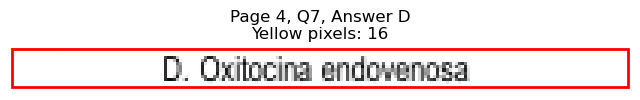


Page 4, Q7 - Selected Answer: A (based on yellow pixel count)
Page 4, Q8 - A: Detected box: x0=56.6, y0=581.7, x1=115.0, y1=594.3
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 275
Page 4, Q8, A: Yellow percentage: 0.0%


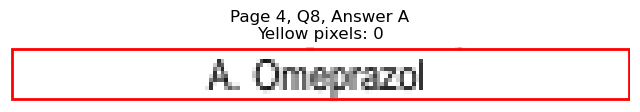

Page 4, Q8 - B: Detected box: x0=56.6, y0=594.3, x1=111.4, y1=606.9
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 273
Page 4, Q8, B: Yellow percentage: 0.0%


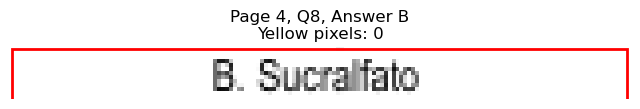

Page 4, Q8 - C: Detected box: x0=315.4, y0=581.7, x1=370.1, y1=594.3
Page 4, Q8, C: Yellow pixels: 1099
Page 4, Q8, C: Total non-white pixels: 1511
Page 4, Q8, C: Yellow percentage: 72.7%


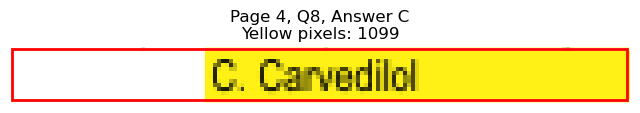

Page 4, Q8 - D: Detected box: x0=315.4, y0=594.3, x1=370.1, y1=606.9
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 387
Page 4, Q8, D: Yellow percentage: 0.0%


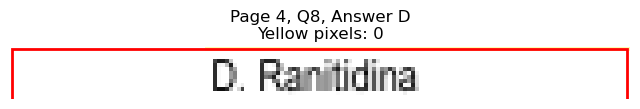


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)
Page 4, Q9 - A: Detected box: x0=56.6, y0=657.4, x1=208.2, y1=670.1
Page 4, Q9, A: Yellow pixels: 2074
Page 4, Q9, A: Total non-white pixels: 2856
Page 4, Q9, A: Yellow percentage: 72.6%


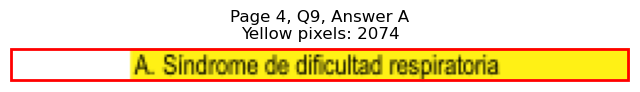

Page 4, Q9 - B: Detected box: x0=56.6, y0=670.0, x1=149.5, y1=682.7
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 583
Page 4, Q9, B: Yellow percentage: 0.0%


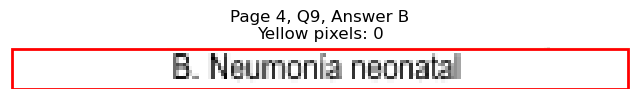

Page 4, Q9 - C: Detected box: x0=315.4, y0=657.4, x1=485.5, y1=670.1
Page 4, Q9, C: Yellow pixels: 208
Page 4, Q9, C: Total non-white pixels: 1119
Page 4, Q9, C: Yellow percentage: 18.6%


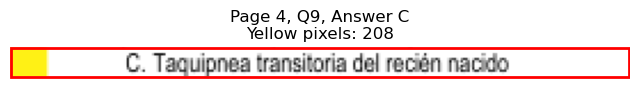

Page 4, Q9 - D: Detected box: x0=315.4, y0=670.0, x1=434.3, y1=682.7
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 618
Page 4, Q9, D: Yellow percentage: 0.0%


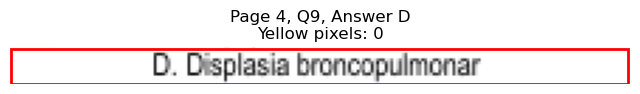


Page 4, Q9 - Selected Answer: A (based on yellow pixel count)
Page 4, Q10 - A: Detected box: x0=56.6, y0=720.6, x1=118.0, y1=733.2
Page 4, Q10, A: Yellow pixels: 1245
Page 4, Q10, A: Total non-white pixels: 1582
Page 4, Q10, A: Yellow percentage: 78.7%


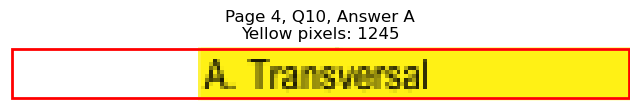

Page 4, Q10 - B: Detected box: x0=56.6, y0=733.2, x1=102.9, y1=745.8
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 312
Page 4, Q10, B: Yellow percentage: 0.0%


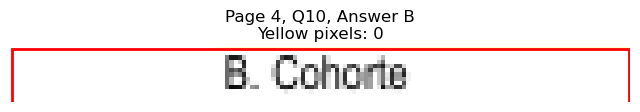

Page 4, Q10 - C: Detected box: x0=315.4, y0=720.6, x1=401.8, y1=733.2
Page 4, Q10, C: Yellow pixels: 208
Page 4, Q10, C: Total non-white pixels: 627
Page 4, Q10, C: Yellow percentage: 33.2%


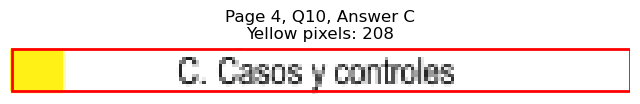

Page 4, Q10 - D: Detected box: x0=315.4, y0=733.2, x1=382.7, y1=745.8
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 356
Page 4, Q10, D: Yellow percentage: 0.0%


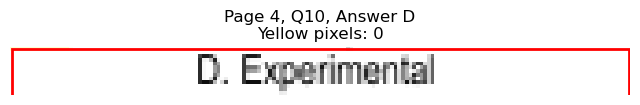


Page 4, Q10 - Selected Answer: A (based on yellow pixel count)

Page 5: Found 9 questions
Page 5, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=139.1, y1=127.3
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 395
Page 5, Q1, A: Yellow percentage: 0.0%


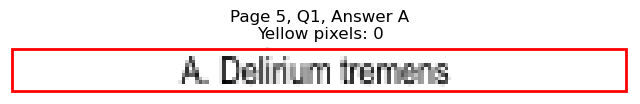

Page 5, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=188.2, y1=139.9
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 630
Page 5, Q1, B: Yellow percentage: 0.0%


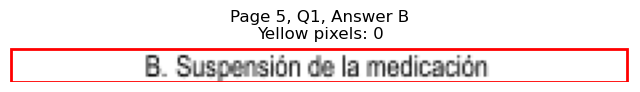

Page 5, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=457.0, y1=127.3
Page 5, Q1, C: Yellow pixels: 1783
Page 5, Q1, C: Total non-white pixels: 2729
Page 5, Q1, C: Yellow percentage: 65.3%


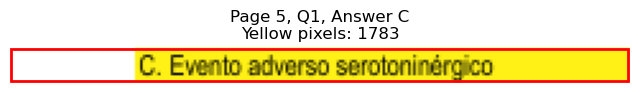

Page 5, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=444.9, y1=139.9
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 793
Page 5, Q1, D: Yellow percentage: 0.0%


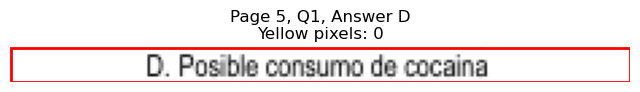


Page 5, Q1 - Selected Answer: C (based on yellow pixel count)
Page 5, Q2 - A: Detected box: x0=56.6, y0=202.9, x1=191.7, y1=215.6
Page 5, Q2, A: Yellow pixels: 1936
Page 5, Q2, A: Total non-white pixels: 2618
Page 5, Q2, A: Yellow percentage: 73.9%


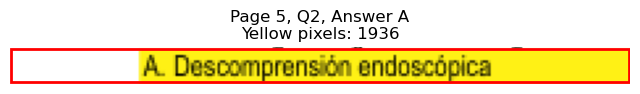

Page 5, Q2 - B: Detected box: x0=56.6, y0=215.6, x1=175.1, y1=228.3
Page 5, Q2, B: Yellow pixels: 171
Page 5, Q2, B: Total non-white pixels: 732
Page 5, Q2, B: Yellow percentage: 23.4%


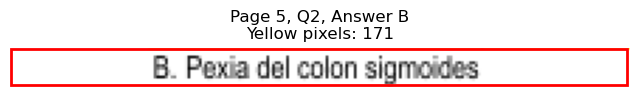

Page 5, Q2 - C: Detected box: x0=315.4, y0=202.9, x1=442.4, y1=215.6
Page 5, Q2, C: Yellow pixels: 208
Page 5, Q2, C: Total non-white pixels: 859
Page 5, Q2, C: Yellow percentage: 24.2%


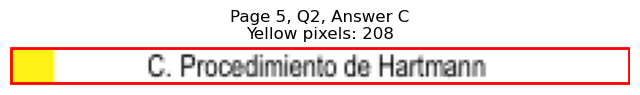

Page 5, Q2 - D: Detected box: x0=315.4, y0=215.6, x1=432.3, y1=228.3
Page 5, Q2, D: Yellow pixels: 16
Page 5, Q2, D: Total non-white pixels: 595
Page 5, Q2, D: Yellow percentage: 2.7%


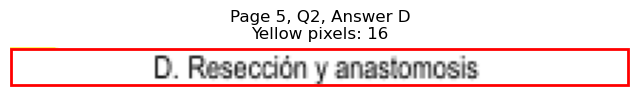


Page 5, Q2 - Selected Answer: A (based on yellow pixel count)
Page 5, Q3 - A: Detected box: x0=56.6, y0=266.0, x1=109.0, y1=278.7
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 237
Page 5, Q3, A: Yellow percentage: 0.0%


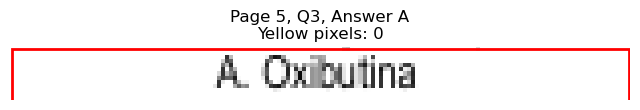

Page 5, Q3 - B: Detected box: x0=56.6, y0=278.8, x1=173.2, y1=291.4
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 583
Page 5, Q3, B: Yellow percentage: 0.0%


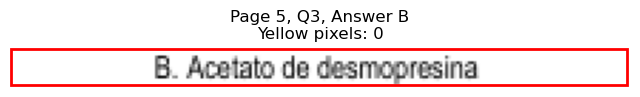

Page 5, Q3 - C: Detected box: x0=315.4, y0=266.0, x1=371.7, y1=278.7
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 260
Page 5, Q3, C: Yellow percentage: 0.0%


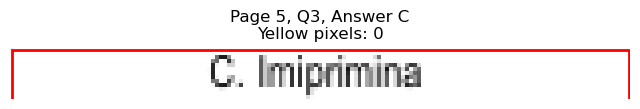

Page 5, Q3 - D: Detected box: x0=315.4, y0=278.8, x1=380.2, y1=291.4
Page 5, Q3, D: Yellow pixels: 1283
Page 5, Q3, D: Total non-white pixels: 1651
Page 5, Q3, D: Yellow percentage: 77.7%


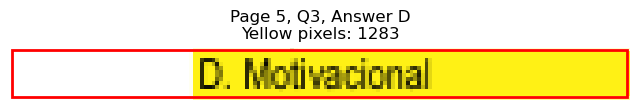


Page 5, Q3 - Selected Answer: D (based on yellow pixel count)
Page 5, Q4 - A: Detected box: x0=56.6, y0=329.2, x1=115.9, y1=341.8
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 283
Page 5, Q4, A: Yellow percentage: 0.0%


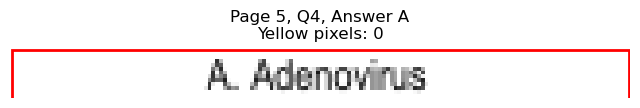

Page 5, Q4 - B: Detected box: x0=56.6, y0=341.9, x1=171.1, y1=354.6
Page 5, Q4, B: Yellow pixels: 1702
Page 5, Q4, B: Total non-white pixels: 2338
Page 5, Q4, B: Yellow percentage: 72.8%


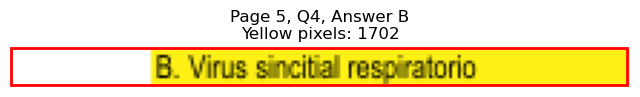

Page 5, Q4 - C: Detected box: x0=315.4, y0=329.2, x1=385.3, y1=341.8
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 324
Page 5, Q4, C: Yellow percentage: 0.0%


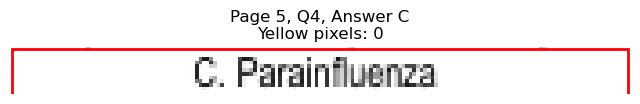

Page 5, Q4 - D: Detected box: x0=315.4, y0=341.9, x1=367.6, y1=354.6
Page 5, Q4, D: Yellow pixels: 208
Page 5, Q4, D: Total non-white pixels: 483
Page 5, Q4, D: Yellow percentage: 43.1%


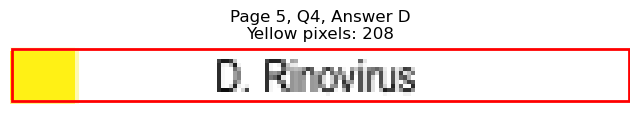


Page 5, Q4 - Selected Answer: B (based on yellow pixel count)
Page 5, Q5 - A: Detected box: x0=56.6, y0=430.2, x1=117.5, y1=442.9
Page 5, Q5, A: Yellow pixels: 1246
Page 5, Q5, A: Total non-white pixels: 1469
Page 5, Q5, A: Yellow percentage: 84.8%


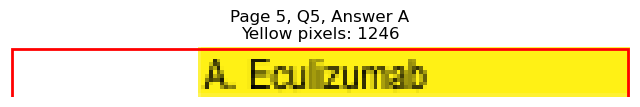

Page 5, Q5 - B: Detected box: x0=56.6, y0=442.8, x1=110.9, y1=455.5
Page 5, Q5, B: Yellow pixels: 106
Page 5, Q5, B: Total non-white pixels: 367
Page 5, Q5, B: Yellow percentage: 28.9%


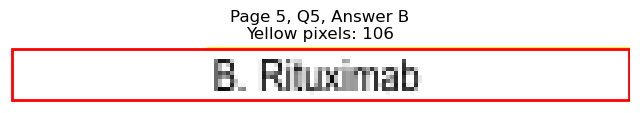

Page 5, Q5 - C: Detected box: x0=315.4, y0=430.2, x1=382.7, y1=442.9
Page 5, Q5, C: Yellow pixels: 208
Page 5, Q5, C: Total non-white pixels: 525
Page 5, Q5, C: Yellow percentage: 39.6%


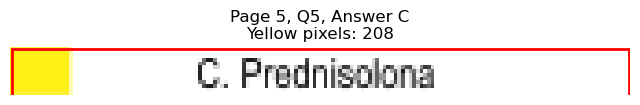

Page 5, Q5 - D: Detected box: x0=315.4, y0=442.8, x1=389.2, y1=455.5
Page 5, Q5, D: Yellow pixels: 16
Page 5, Q5, D: Total non-white pixels: 393
Page 5, Q5, D: Yellow percentage: 4.1%


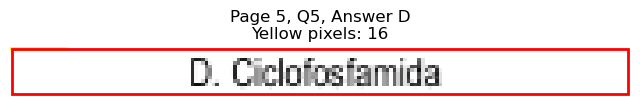


Page 5, Q5 - Selected Answer: A (based on yellow pixel count)
Page 5, Q6 - A: Detected box: x0=56.6, y0=506.0, x1=175.6, y1=518.6
Page 5, Q6, A: Yellow pixels: 1801
Page 5, Q6, A: Total non-white pixels: 2394
Page 5, Q6, A: Yellow percentage: 75.2%


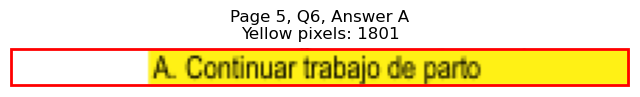

Page 5, Q6 - B: Detected box: x0=56.6, y0=518.6, x1=139.0, y1=531.2
Page 5, Q6, B: Yellow pixels: 133
Page 5, Q6, B: Total non-white pixels: 511
Page 5, Q6, B: Yellow percentage: 26.0%


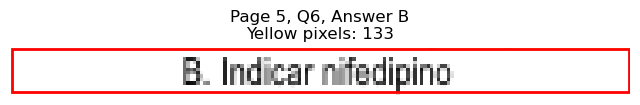

Page 5, Q6 - C: Detected box: x0=315.4, y0=506.0, x1=391.7, y1=518.6
Page 5, Q6, C: Yellow pixels: 208
Page 5, Q6, C: Total non-white pixels: 613
Page 5, Q6, C: Yellow percentage: 33.9%


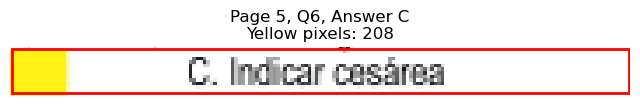

Page 5, Q6 - D: Detected box: x0=315.4, y0=518.6, x1=473.5, y1=531.2
Page 5, Q6, D: Yellow pixels: 16
Page 5, Q6, D: Total non-white pixels: 823
Page 5, Q6, D: Yellow percentage: 1.9%


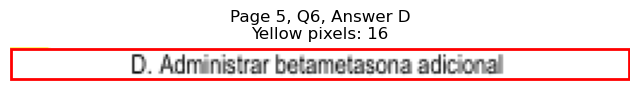


Page 5, Q6 - Selected Answer: A (based on yellow pixel count)
Page 5, Q7 - A: Detected box: x0=56.6, y0=581.7, x1=162.1, y1=594.3
Page 5, Q7, A: Yellow pixels: 158
Page 5, Q7, A: Total non-white pixels: 652
Page 5, Q7, A: Yellow percentage: 24.2%


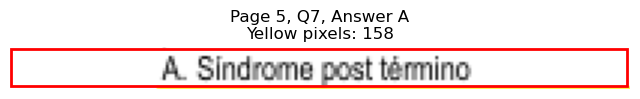

Page 5, Q7 - B: Detected box: x0=56.6, y0=594.3, x1=101.4, y1=606.9
Page 5, Q7, B: Yellow pixels: 1089
Page 5, Q7, B: Total non-white pixels: 1261
Page 5, Q7, B: Yellow percentage: 86.4%


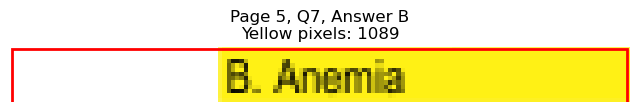

Page 5, Q7 - C: Detected box: x0=315.4, y0=581.7, x1=379.7, y1=594.3
Page 5, Q7, C: Yellow pixels: 16
Page 5, Q7, C: Total non-white pixels: 317
Page 5, Q7, C: Yellow percentage: 5.0%


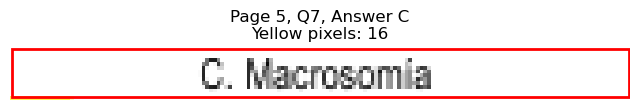

Page 5, Q7 - D: Detected box: x0=315.4, y0=594.3, x1=382.3, y1=606.9
Page 5, Q7, D: Yellow pixels: 208
Page 5, Q7, D: Total non-white pixels: 551
Page 5, Q7, D: Yellow percentage: 37.7%


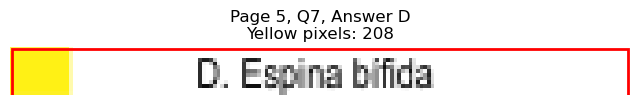


Page 5, Q7 - Selected Answer: B (based on yellow pixel count)
Page 5, Q8 - A: Detected box: x0=56.6, y0=657.4, x1=112.0, y1=670.1
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 248
Page 5, Q8, A: Yellow percentage: 0.0%


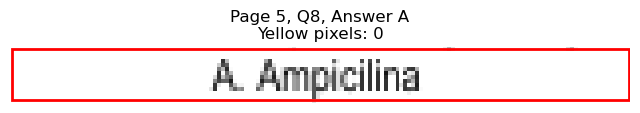

Page 5, Q8 - B: Detected box: x0=56.6, y0=670.0, x1=118.9, y1=682.7
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 308
Page 5, Q8, B: Yellow percentage: 0.0%


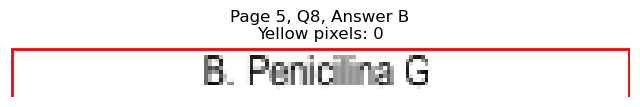

Page 5, Q8 - C: Detected box: x0=315.4, y0=657.4, x1=381.7, y1=670.1
Page 5, Q8, C: Yellow pixels: 118
Page 5, Q8, C: Total non-white pixels: 419
Page 5, Q8, C: Yellow percentage: 28.2%


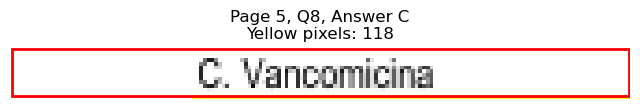

Page 5, Q8 - D: Detected box: x0=315.4, y0=670.0, x1=376.1, y1=682.7
Page 5, Q8, D: Yellow pixels: 1238
Page 5, Q8, D: Total non-white pixels: 1482
Page 5, Q8, D: Yellow percentage: 83.5%


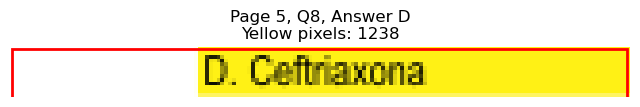


Page 5, Q8 - Selected Answer: D (based on yellow pixel count)
Page 5, Q9 - A: Detected box: x0=56.6, y0=733.2, x1=102.5, y1=745.8
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 318
Page 5, Q9, A: Yellow percentage: 0.0%


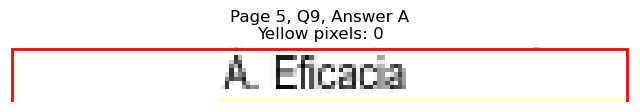

Page 5, Q9 - B: Detected box: x0=56.6, y0=745.8, x1=109.5, y1=758.4
Page 5, Q9, B: Yellow pixels: 1176
Page 5, Q9, B: Total non-white pixels: 1470
Page 5, Q9, B: Yellow percentage: 80.0%


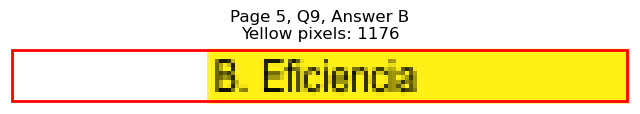

Page 5, Q9 - C: Detected box: x0=315.4, y0=733.2, x1=374.2, y1=745.8
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 293
Page 5, Q9, C: Yellow percentage: 0.0%


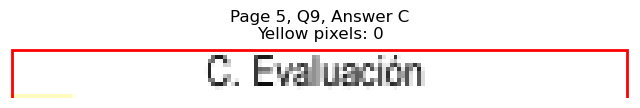


Page 5, Q9 - Selected Answer: B (based on yellow pixel count)

Page 6: Found 9 questions
Page 6, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=133.6, y1=127.3
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 351
Page 6, Q1, A: Yellow percentage: 0.0%


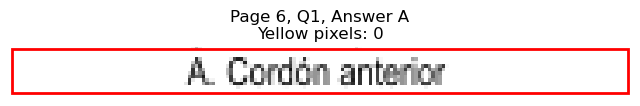

Page 6, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=119.4, y1=139.9
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 296
Page 6, Q1, B: Yellow percentage: 0.0%


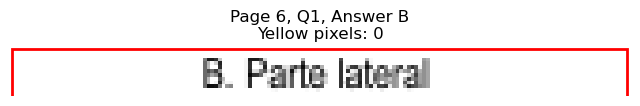

Page 6, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=351.7, y1=127.3
Page 6, Q1, C: Yellow pixels: 88
Page 6, Q1, C: Total non-white pixels: 254
Page 6, Q1, C: Yellow percentage: 34.6%


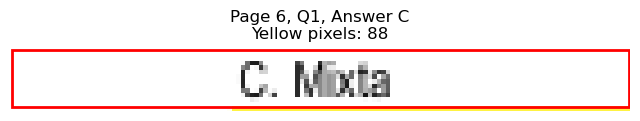

Page 6, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=397.3, y1=139.9
Page 6, Q1, D: Yellow pixels: 1445
Page 6, Q1, D: Total non-white pixels: 1755
Page 6, Q1, D: Yellow percentage: 82.3%


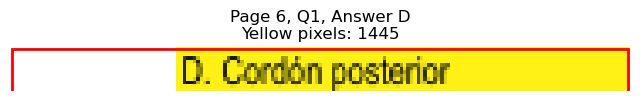


Page 6, Q1 - Selected Answer: D (based on yellow pixel count)
Page 6, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=134.5, y1=203.0
Page 6, Q2, A: Yellow pixels: 1385
Page 6, Q2, A: Total non-white pixels: 1690
Page 6, Q2, A: Yellow percentage: 82.0%


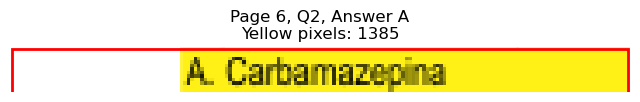

Page 6, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=109.0, y1=215.6
Page 6, Q2, B: Yellow pixels: 102
Page 6, Q2, B: Total non-white pixels: 333
Page 6, Q2, B: Yellow percentage: 30.6%


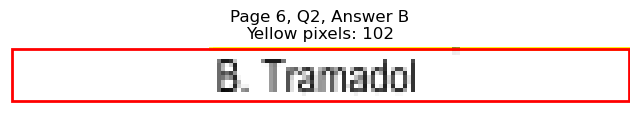

Page 6, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=404.2, y1=203.0
Page 6, Q2, C: Yellow pixels: 208
Page 6, Q2, C: Total non-white pixels: 679
Page 6, Q2, C: Yellow percentage: 30.6%


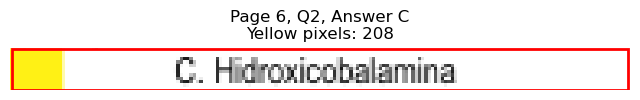

Page 6, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=386.7, y1=215.6
Page 6, Q2, D: Yellow pixels: 16
Page 6, Q2, D: Total non-white pixels: 341
Page 6, Q2, D: Yellow percentage: 4.7%


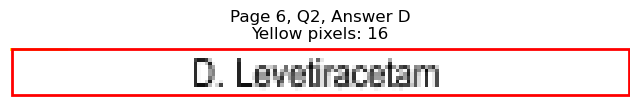


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)
Page 6, Q3 - A: Detected box: x0=56.6, y0=266.0, x1=135.0, y1=278.7
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 394
Page 6, Q3, A: Yellow percentage: 0.0%


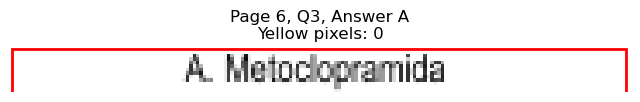

Page 6, Q3 - B: Detected box: x0=56.6, y0=278.8, x1=119.4, y1=291.4
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 305
Page 6, Q3, B: Yellow percentage: 0.0%


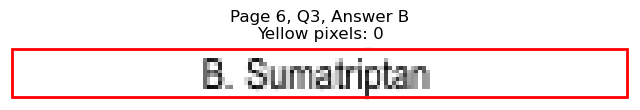

Page 6, Q3 - C: Detected box: x0=315.4, y0=266.0, x1=376.1, y1=278.7
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 293
Page 6, Q3, C: Yellow percentage: 0.0%


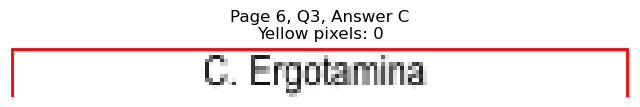

Page 6, Q3 - D: Detected box: x0=315.4, y0=278.8, x1=373.1, y1=291.4
Page 6, Q3, D: Yellow pixels: 1245
Page 6, Q3, D: Total non-white pixels: 1553
Page 6, Q3, D: Yellow percentage: 80.2%


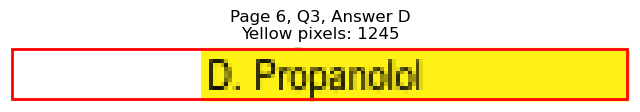


Page 6, Q3 - Selected Answer: D (based on yellow pixel count)
Page 6, Q4 - A: Detected box: x0=56.6, y0=341.9, x1=171.1, y1=354.6
Page 6, Q4, A: Yellow pixels: 1737
Page 6, Q4, A: Total non-white pixels: 2338
Page 6, Q4, A: Yellow percentage: 74.3%


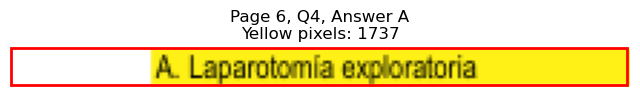

Page 6, Q4 - B: Detected box: x0=56.6, y0=354.5, x1=93.9, y1=367.2
Page 6, Q4, B: Yellow pixels: 88
Page 6, Q4, B: Total non-white pixels: 238
Page 6, Q4, B: Yellow percentage: 37.0%


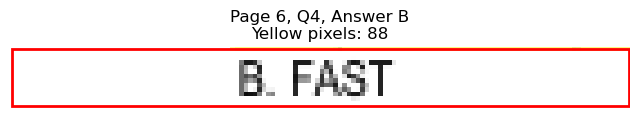

Page 6, Q4 - C: Detected box: x0=315.4, y0=341.9, x1=420.3, y1=354.6
Page 6, Q4, C: Yellow pixels: 208
Page 6, Q4, C: Total non-white pixels: 750
Page 6, Q4, C: Yellow percentage: 27.7%


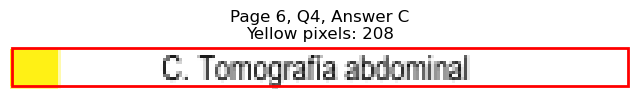

Page 6, Q4 - D: Detected box: x0=315.4, y0=354.5, x1=433.9, y1=367.2
Page 6, Q4, D: Yellow pixels: 16
Page 6, Q4, D: Total non-white pixels: 580
Page 6, Q4, D: Yellow percentage: 2.8%


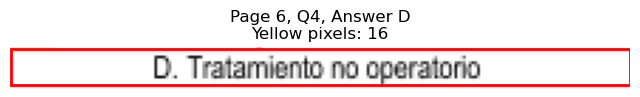


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)
Page 6, Q5 - A: Detected box: x0=56.6, y0=392.3, x1=111.4, y1=405.0
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 383
Page 6, Q5, A: Yellow percentage: 0.0%


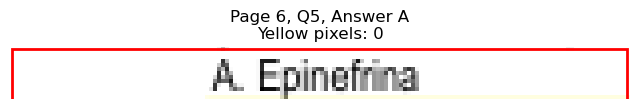

Page 6, Q5 - B: Detected box: x0=56.6, y0=404.9, x1=101.5, y1=417.6
Page 6, Q5, B: Yellow pixels: 1089
Page 6, Q5, B: Total non-white pixels: 1358
Page 6, Q5, B: Yellow percentage: 80.2%


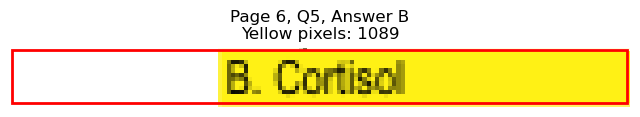

Page 6, Q5 - C: Detected box: x0=315.4, y0=392.3, x1=368.7, y1=405.0
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 253
Page 6, Q5, C: Yellow percentage: 0.0%


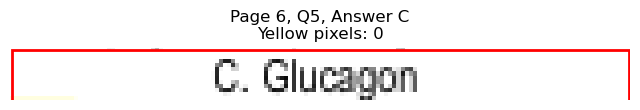

Page 6, Q5 - D: Detected box: x0=315.4, y0=404.9, x1=361.1, y1=417.6
Page 6, Q5, D: Yellow pixels: 208
Page 6, Q5, D: Total non-white pixels: 464
Page 6, Q5, D: Yellow percentage: 44.8%


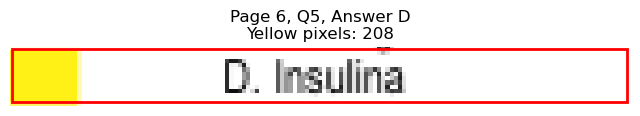


Page 6, Q5 - Selected Answer: B (based on yellow pixel count)
Page 6, Q6 - A: Detected box: x0=56.6, y0=468.1, x1=100.9, y1=480.7
Page 6, Q6, A: Yellow pixels: 1093
Page 6, Q6, A: Total non-white pixels: 1248
Page 6, Q6, A: Yellow percentage: 87.6%


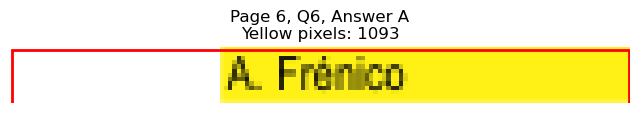

Page 6, Q6 - B: Detected box: x0=56.6, y0=480.8, x1=132.5, y1=493.4
Page 6, Q6, B: Yellow pixels: 128
Page 6, Q6, B: Total non-white pixels: 511
Page 6, Q6, B: Yellow percentage: 25.0%


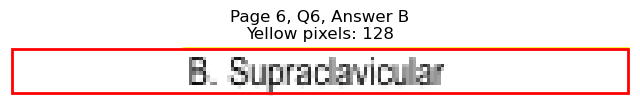

Page 6, Q6 - C: Detected box: x0=315.4, y0=468.1, x1=370.1, y1=480.7
Page 6, Q6, C: Yellow pixels: 208
Page 6, Q6, C: Total non-white pixels: 496
Page 6, Q6, C: Yellow percentage: 41.9%


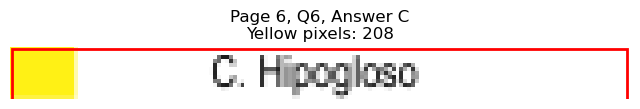

Page 6, Q6 - D: Detected box: x0=315.4, y0=480.8, x1=351.2, y1=493.4
Page 6, Q6, D: Yellow pixels: 16
Page 6, Q6, D: Total non-white pixels: 178
Page 6, Q6, D: Yellow percentage: 9.0%


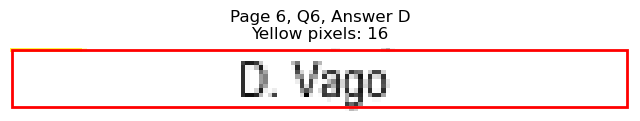


Page 6, Q6 - Selected Answer: A (based on yellow pixel count)
Page 6, Q7 - A: Detected box: x0=56.6, y0=543.8, x1=207.4, y1=556.4
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 807
Page 6, Q7, A: Yellow percentage: 0.0%


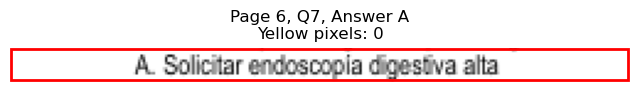

Page 6, Q7 - B: Detected box: x0=56.6, y0=556.5, x1=198.3, y1=569.1
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 684
Page 6, Q7, B: Yellow percentage: 0.0%


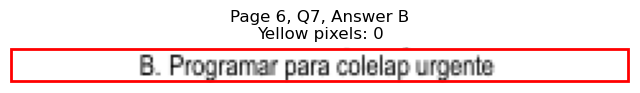

Page 6, Q7 - C: Detected box: x0=315.4, y0=543.8, x1=419.3, y1=556.4
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 522
Page 6, Q7, C: Yellow percentage: 0.0%


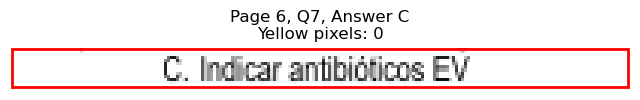

Page 6, Q7 - D: Detected box: x0=315.4, y0=556.5, x1=445.4, y1=569.1
Page 6, Q7, D: Yellow pixels: 1896
Page 6, Q7, D: Total non-white pixels: 2561
Page 6, Q7, D: Yellow percentage: 74.0%


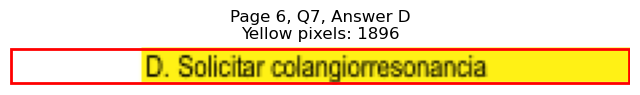


Page 6, Q7 - Selected Answer: D (based on yellow pixel count)
Page 6, Q8 - A: Detected box: x0=56.6, y0=619.6, x1=118.5, y1=632.3
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 316
Page 6, Q8, A: Yellow percentage: 0.0%


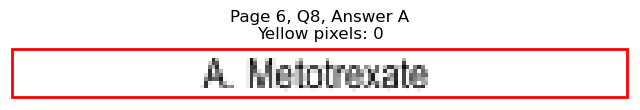

Page 6, Q8 - B: Detected box: x0=56.6, y0=632.2, x1=115.9, y1=644.9
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 262
Page 6, Q8, B: Yellow percentage: 0.0%


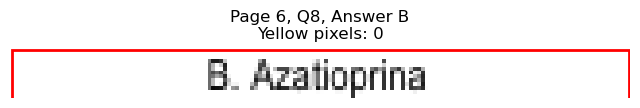

Page 6, Q8 - C: Detected box: x0=315.4, y0=619.6, x1=445.4, y1=632.3
Page 6, Q8, C: Yellow pixels: 1716
Page 6, Q8, C: Total non-white pixels: 2561
Page 6, Q8, C: Yellow percentage: 67.0%


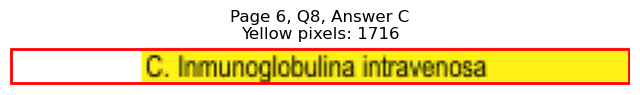

Page 6, Q8 - D: Detected box: x0=315.4, y0=632.2, x1=400.7, y1=644.9
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 578
Page 6, Q8, D: Yellow percentage: 0.0%


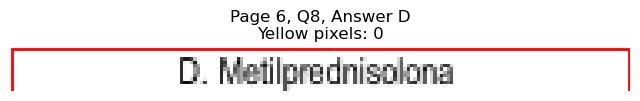


Page 6, Q8 - Selected Answer: C (based on yellow pixel count)
Page 6, Q9 - A: Detected box: x0=56.6, y0=708.0, x1=135.5, y1=720.6
Page 6, Q9, A: Yellow pixels: 130
Page 6, Q9, A: Total non-white pixels: 536
Page 6, Q9, A: Yellow percentage: 24.3%


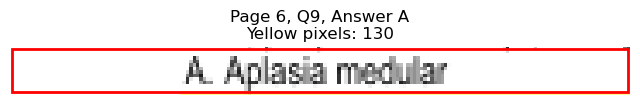

Page 6, Q9 - B: Detected box: x0=56.6, y0=720.6, x1=109.9, y1=733.2
Page 6, Q9, B: Yellow pixels: 1175
Page 6, Q9, B: Total non-white pixels: 1470
Page 6, Q9, B: Yellow percentage: 79.9%


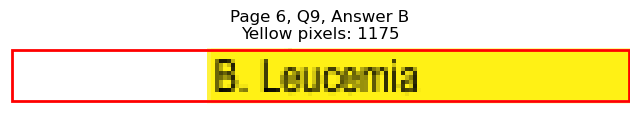

Page 6, Q9 - C: Detected box: x0=315.4, y0=708.0, x1=446.9, y1=720.6
Page 6, Q9, C: Yellow pixels: 16
Page 6, Q9, C: Total non-white pixels: 650
Page 6, Q9, C: Yellow percentage: 2.5%


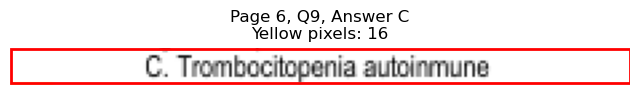

Page 6, Q9 - D: Detected box: x0=315.4, y0=720.6, x1=364.6, y1=733.2
Page 6, Q9, D: Yellow pixels: 208
Page 6, Q9, D: Total non-white pixels: 425
Page 6, Q9, D: Yellow percentage: 48.9%


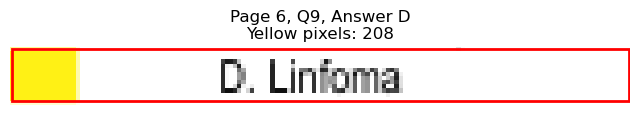


Page 6, Q9 - Selected Answer: B (based on yellow pixel count)

Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=103.9, y1=114.7
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 231
Page 7, Q1, A: Yellow percentage: 0.0%


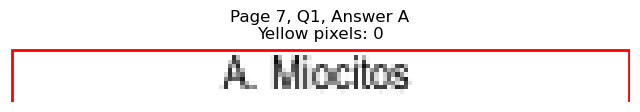

Page 7, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=175.1, y1=127.3
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 585
Page 7, Q1, B: Yellow percentage: 0.0%


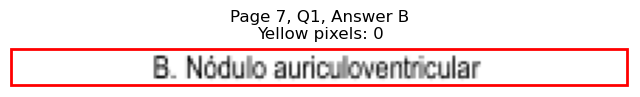

Page 7, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=402.8, y1=114.7
Page 7, Q1, C: Yellow pixels: 1472
Page 7, Q1, C: Total non-white pixels: 1820
Page 7, Q1, C: Yellow percentage: 80.9%


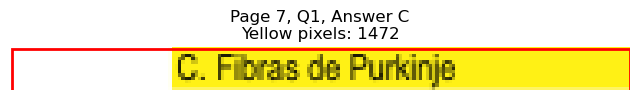

Page 7, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=412.3, y1=127.3
Page 7, Q1, D: Yellow pixels: 148
Page 7, Q1, D: Total non-white pixels: 633
Page 7, Q1, D: Yellow percentage: 23.4%


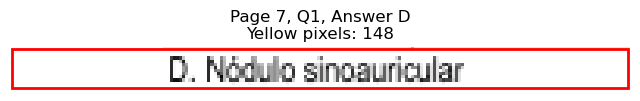


Page 7, Q1 - Selected Answer: C (based on yellow pixel count)
Page 7, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=95.9, y1=177.8
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 255
Page 7, Q2, A: Yellow percentage: 0.0%


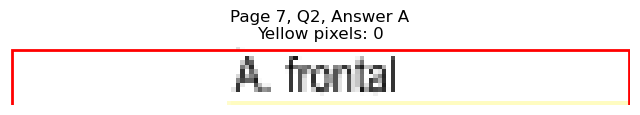

Page 7, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=138.0, y1=190.4
Page 7, Q2, B: Yellow pixels: 1301
Page 7, Q2, B: Total non-white pixels: 1876
Page 7, Q2, B: Yellow percentage: 69.3%


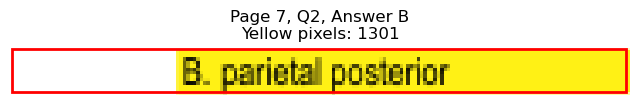

Page 7, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=362.7, y1=177.8
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 252
Page 7, Q2, C: Yellow percentage: 0.0%


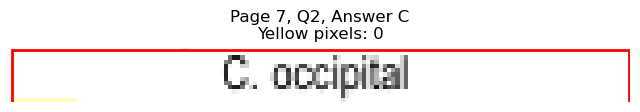

Page 7, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=392.7, y1=190.4
Page 7, Q2, D: Yellow pixels: 192
Page 7, Q2, D: Total non-white pixels: 614
Page 7, Q2, D: Yellow percentage: 31.3%


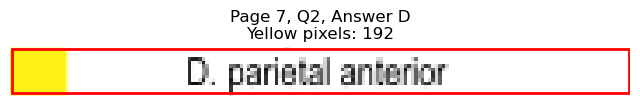


Page 7, Q2 - Selected Answer: B (based on yellow pixel count)
Page 7, Q3 - A: Detected box: x0=56.6, y0=240.8, x1=160.7, y1=253.5
Page 7, Q3, A: Yellow pixels: 156
Page 7, Q3, A: Total non-white pixels: 634
Page 7, Q3, A: Yellow percentage: 24.6%


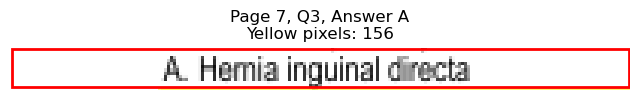

Page 7, Q3 - B: Detected box: x0=56.6, y0=253.4, x1=142.6, y1=266.1
Page 7, Q3, B: Yellow pixels: 1452
Page 7, Q3, B: Total non-white pixels: 1932
Page 7, Q3, B: Yellow percentage: 75.2%


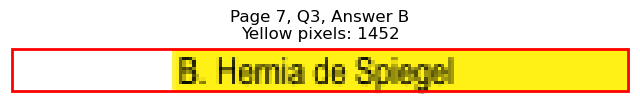

Page 7, Q3 - C: Detected box: x0=315.4, y0=240.8, x1=406.4, y1=253.5
Page 7, Q3, C: Yellow pixels: 16
Page 7, Q3, C: Total non-white pixels: 482
Page 7, Q3, C: Yellow percentage: 3.3%


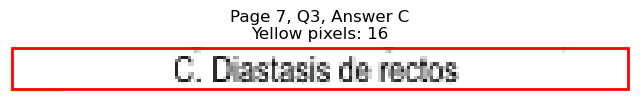

Page 7, Q3 - D: Detected box: x0=315.4, y0=253.4, x1=422.0, y1=266.1
Page 7, Q3, D: Yellow pixels: 208
Page 7, Q3, D: Total non-white pixels: 757
Page 7, Q3, D: Yellow percentage: 27.5%


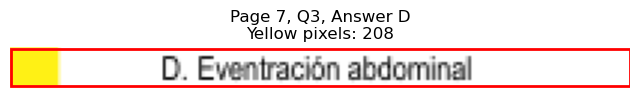


Page 7, Q3 - Selected Answer: B (based on yellow pixel count)
Page 7, Q4 - A: Detected box: x0=56.6, y0=304.0, x1=141.5, y1=316.6
Page 7, Q4, A: Yellow pixels: 2
Page 7, Q4, A: Total non-white pixels: 554
Page 7, Q4, A: Yellow percentage: 0.4%


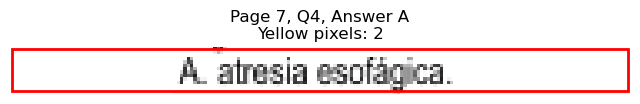

Page 7, Q4 - B: Detected box: x0=56.6, y0=316.6, x1=169.1, y1=329.2
Page 7, Q4, B: Yellow pixels: 1565
Page 7, Q4, B: Total non-white pixels: 2310
Page 7, Q4, B: Yellow percentage: 67.7%


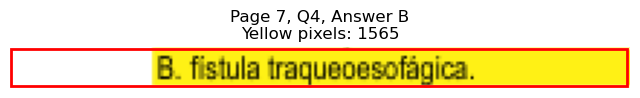

Page 7, Q4 - C: Detected box: x0=315.4, y0=304.0, x1=423.3, y1=316.6
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 555
Page 7, Q4, C: Yellow percentage: 0.0%


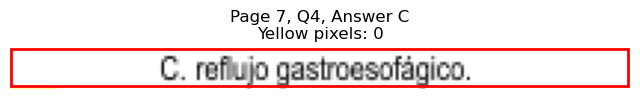

Page 7, Q4 - D: Detected box: x0=315.4, y0=316.6, x1=403.7, y1=329.2
Page 7, Q4, D: Yellow pixels: 192
Page 7, Q4, D: Total non-white pixels: 665
Page 7, Q4, D: Yellow percentage: 28.9%


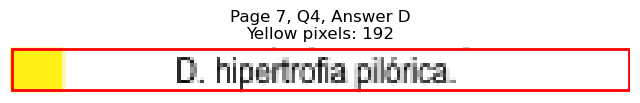


Page 7, Q4 - Selected Answer: B (based on yellow pixel count)
Page 7, Q5 - A: Detected box: x0=56.6, y0=367.1, x1=188.2, y1=379.8
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 655
Page 7, Q5, A: Yellow percentage: 0.0%


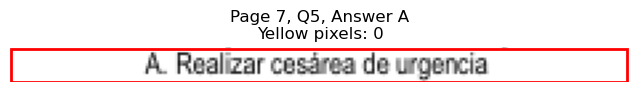

Page 7, Q5 - B: Detected box: x0=56.6, y0=379.7, x1=187.2, y1=392.4
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 666
Page 7, Q5, B: Yellow percentage: 0.0%


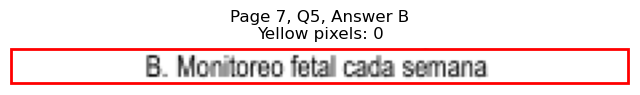

Page 7, Q5 - C: Detected box: x0=315.4, y0=367.1, x1=440.3, y1=379.8
Page 7, Q5, C: Yellow pixels: 2
Page 7, Q5, C: Total non-white pixels: 770
Page 7, Q5, C: Yellow percentage: 0.3%


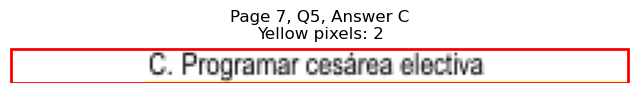

Page 7, Q5 - D: Detected box: x0=315.4, y0=379.7, x1=460.4, y1=392.4
Page 7, Q5, D: Yellow pixels: 1867
Page 7, Q5, D: Total non-white pixels: 2770
Page 7, Q5, D: Yellow percentage: 67.4%


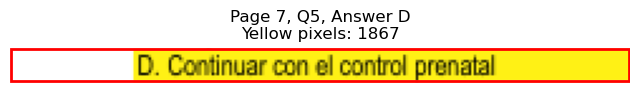


Page 7, Q5 - Selected Answer: D (based on yellow pixel count)
Page 7, Q6 - A: Detected box: x0=56.6, y0=417.6, x1=129.5, y1=430.3
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 362
Page 7, Q6, A: Yellow percentage: 0.0%


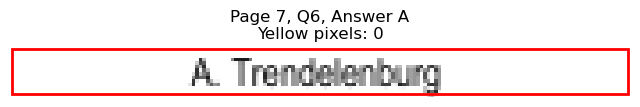

Page 7, Q6 - B: Detected box: x0=56.6, y0=430.2, x1=135.5, y1=442.9
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 380
Page 7, Q6, B: Yellow percentage: 0.0%


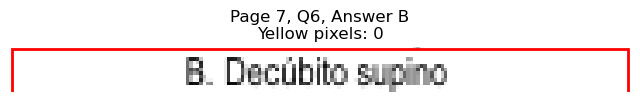

Page 7, Q6 - C: Detected box: x0=315.4, y0=417.6, x1=391.3, y1=430.3
Page 7, Q6, C: Yellow pixels: 1272
Page 7, Q6, C: Total non-white pixels: 1805
Page 7, Q6, C: Yellow percentage: 70.5%


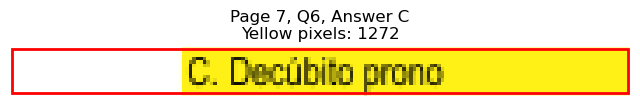

Page 7, Q6 - D: Detected box: x0=315.4, y0=430.2, x1=392.7, y1=442.9
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 517
Page 7, Q6, D: Yellow percentage: 0.0%


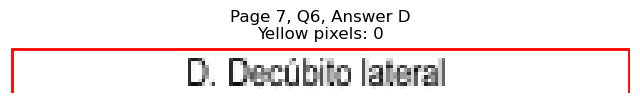


Page 7, Q6 - Selected Answer: C (based on yellow pixel count)
Page 7, Q7 - A: Detected box: x0=56.6, y0=506.0, x1=179.2, y1=518.6
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 599
Page 7, Q7, A: Yellow percentage: 0.0%


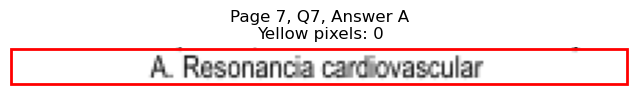

Page 7, Q7 - B: Detected box: x0=56.6, y0=518.6, x1=162.6, y1=531.2
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 500
Page 7, Q7, B: Yellow percentage: 0.0%


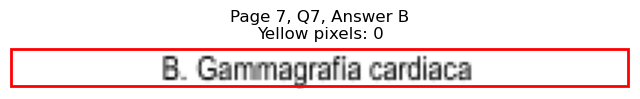

Page 7, Q7 - C: Detected box: x0=315.4, y0=506.0, x1=436.9, y1=518.6
Page 7, Q7, C: Yellow pixels: 173
Page 7, Q7, C: Total non-white pixels: 755
Page 7, Q7, C: Yellow percentage: 22.9%


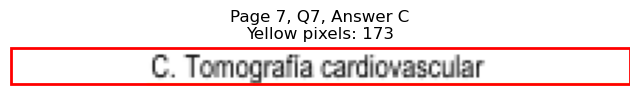

Page 7, Q7 - D: Detected box: x0=315.4, y0=518.6, x1=453.4, y1=531.2
Page 7, Q7, D: Yellow pixels: 1983
Page 7, Q7, D: Total non-white pixels: 2673
Page 7, Q7, D: Yellow percentage: 74.2%


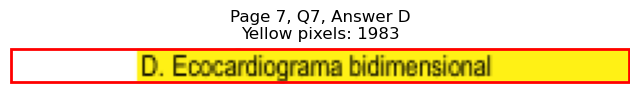


Page 7, Q7 - Selected Answer: D (based on yellow pixel count)
Page 7, Q8 - A: Detected box: x0=56.6, y0=569.1, x1=136.5, y1=581.7
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 373
Page 7, Q8, A: Yellow percentage: 0.0%


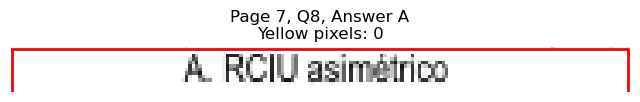

Page 7, Q8 - B: Detected box: x0=56.6, y0=581.7, x1=124.5, y1=594.3
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 300
Page 7, Q8, B: Yellow percentage: 0.0%


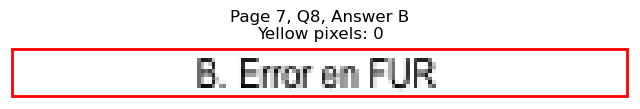

Page 7, Q8 - C: Detected box: x0=315.4, y0=569.1, x1=390.7, y1=581.7
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 478
Page 7, Q8, C: Yellow percentage: 0.0%


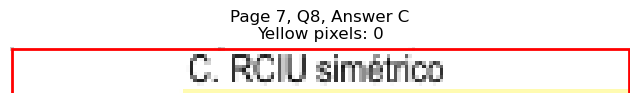

Page 7, Q8 - D: Detected box: x0=315.4, y0=581.7, x1=469.5, y1=594.3
Page 7, Q8, D: Yellow pixels: 1877
Page 7, Q8, D: Total non-white pixels: 2896
Page 7, Q8, D: Yellow percentage: 64.8%


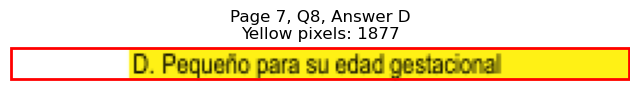


Page 7, Q8 - Selected Answer: D (based on yellow pixel count)
Page 7, Q9 - A: Detected box: x0=56.6, y0=632.2, x1=113.9, y1=644.9
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 272
Page 7, Q9, A: Yellow percentage: 0.0%


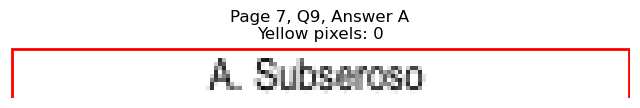

Page 7, Q9 - B: Detected box: x0=56.6, y0=644.8, x1=115.5, y1=657.5
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 304
Page 7, Q9, B: Yellow percentage: 0.0%


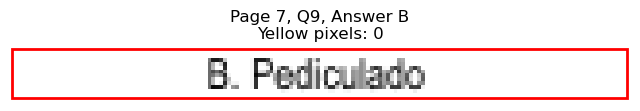

Page 7, Q9 - C: Detected box: x0=315.4, y0=632.2, x1=370.6, y1=644.9
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 356
Page 7, Q9, C: Yellow percentage: 0.0%


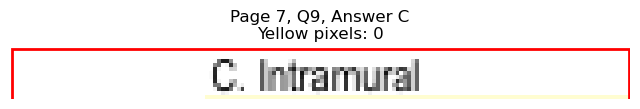

Page 7, Q9 - D: Detected box: x0=315.4, y0=644.8, x1=377.7, y1=657.5
Page 7, Q9, D: Yellow pixels: 1269
Page 7, Q9, D: Total non-white pixels: 1609
Page 7, Q9, D: Yellow percentage: 78.9%


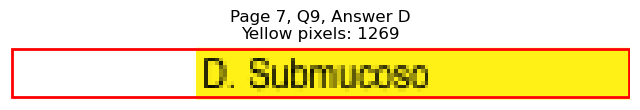


Page 7, Q9 - Selected Answer: D (based on yellow pixel count)
Page 7, Q10 - A: Detected box: x0=56.6, y0=695.4, x1=176.7, y1=708.0
Page 7, Q10, A: Yellow pixels: 1782
Page 7, Q10, A: Total non-white pixels: 2237
Page 7, Q10, A: Yellow percentage: 79.7%


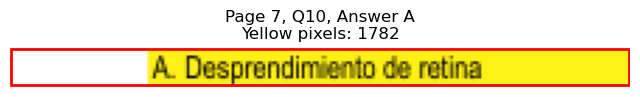

Page 7, Q10 - B: Detected box: x0=56.6, y0=708.0, x1=133.5, y1=720.6
Page 7, Q10, B: Yellow pixels: 128
Page 7, Q10, B: Total non-white pixels: 510
Page 7, Q10, B: Yellow percentage: 25.1%


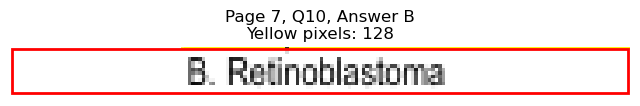

Page 7, Q10 - C: Detected box: x0=315.4, y0=695.4, x1=417.8, y1=708.0
Page 7, Q10, C: Yellow pixels: 208
Page 7, Q10, C: Total non-white pixels: 704
Page 7, Q10, C: Yellow percentage: 29.5%


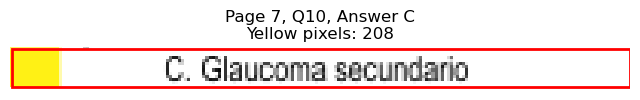


Page 7, Q10 - Selected Answer: A (based on yellow pixel count)

Page 8: Found 9 questions
Page 8, Q1 - A: Detected box: x0=56.6, y0=127.2, x1=140.1, y1=139.9
Page 8, Q1, A: Yellow pixels: 1448
Page 8, Q1, A: Total non-white pixels: 1768
Page 8, Q1, A: Yellow percentage: 81.9%


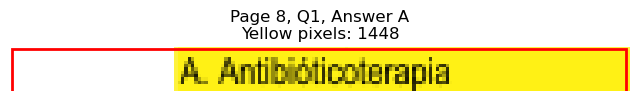

Page 8, Q1 - B: Detected box: x0=56.6, y0=139.9, x1=126.0, y1=152.6
Page 8, Q1, B: Yellow pixels: 121
Page 8, Q1, B: Total non-white pixels: 478
Page 8, Q1, B: Yellow percentage: 25.3%


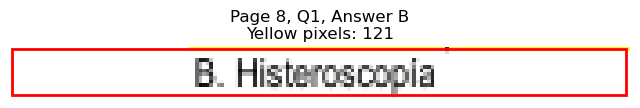

Page 8, Q1 - C: Detected box: x0=315.4, y0=127.2, x1=430.4, y1=139.9
Page 8, Q1, C: Yellow pixels: 208
Page 8, Q1, C: Total non-white pixels: 770
Page 8, Q1, C: Yellow percentage: 27.0%


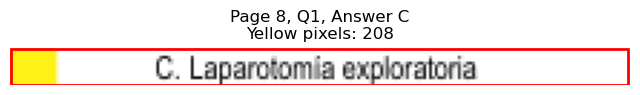

Page 8, Q1 - D: Detected box: x0=315.4, y0=139.9, x1=394.3, y1=152.6
Page 8, Q1, D: Yellow pixels: 16
Page 8, Q1, D: Total non-white pixels: 420
Page 8, Q1, D: Yellow percentage: 3.8%


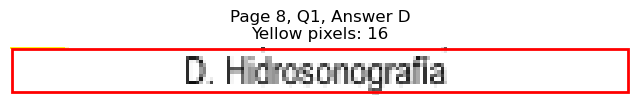


Page 8, Q1 - Selected Answer: A (based on yellow pixel count)
Page 8, Q2 - A: Detected box: x0=56.6, y0=215.6, x1=108.4, y1=228.3
Page 8, Q2, A: Yellow pixels: 1044
Page 8, Q2, A: Total non-white pixels: 1456
Page 8, Q2, A: Yellow percentage: 71.7%


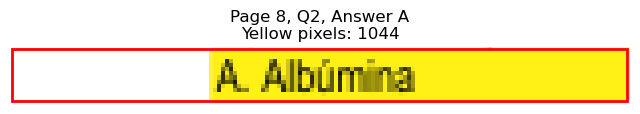

Page 8, Q2 - B: Detected box: x0=56.6, y0=228.2, x1=129.5, y1=240.9
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 481
Page 8, Q2, B: Yellow percentage: 0.0%


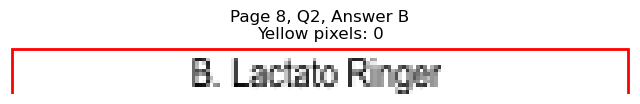

Page 8, Q2 - C: Detected box: x0=315.4, y0=215.6, x1=369.2, y1=228.3
Page 8, Q2, C: Yellow pixels: 192
Page 8, Q2, C: Total non-white pixels: 480
Page 8, Q2, C: Yellow percentage: 40.0%


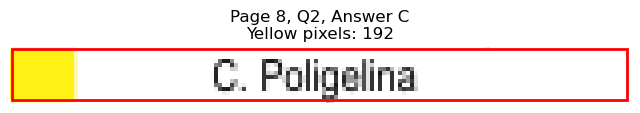

Page 8, Q2 - D: Detected box: x0=315.4, y0=228.2, x1=381.7, y1=240.9
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 333
Page 8, Q2, D: Yellow percentage: 0.0%


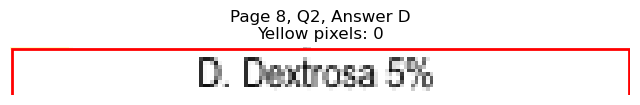


Page 8, Q2 - Selected Answer: A (based on yellow pixel count)
Page 8, Q3 - A: Detected box: x0=56.6, y0=291.4, x1=179.7, y1=304.0
Page 8, Q3, A: Yellow pixels: 1825
Page 8, Q3, A: Total non-white pixels: 2450
Page 8, Q3, A: Yellow percentage: 74.5%


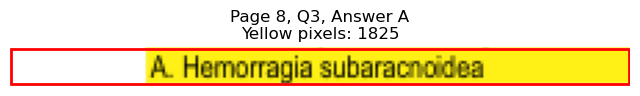

Page 8, Q3 - B: Detected box: x0=56.6, y0=304.0, x1=173.2, y1=316.6
Page 8, Q3, B: Yellow pixels: 165
Page 8, Q3, B: Total non-white pixels: 960
Page 8, Q3, B: Yellow percentage: 17.2%


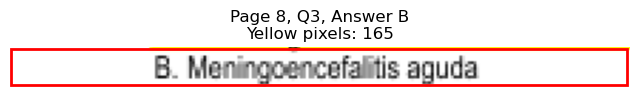

Page 8, Q3 - C: Detected box: x0=315.4, y0=291.4, x1=446.8, y1=304.0
Page 8, Q3, C: Yellow pixels: 208
Page 8, Q3, C: Total non-white pixels: 901
Page 8, Q3, C: Yellow percentage: 23.1%


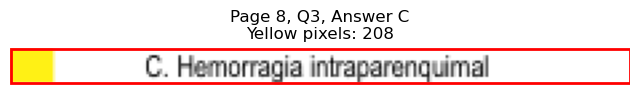

Page 8, Q3 - D: Detected box: x0=315.4, y0=304.0, x1=382.7, y1=316.6
Page 8, Q3, D: Yellow pixels: 16
Page 8, Q3, D: Total non-white pixels: 357
Page 8, Q3, D: Yellow percentage: 4.5%


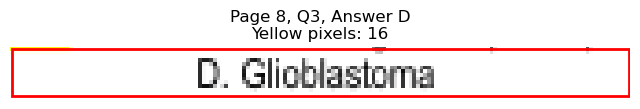


Page 8, Q3 - Selected Answer: A (based on yellow pixel count)
Page 8, Q4 - A: Detected box: x0=56.6, y0=367.1, x1=155.5, y1=379.8
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 500
Page 8, Q4, A: Yellow percentage: 0.0%


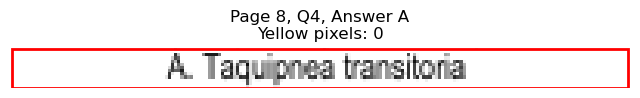

Page 8, Q4 - B: Detected box: x0=56.6, y0=379.7, x1=135.0, y1=392.4
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 393
Page 8, Q4, B: Yellow percentage: 0.0%


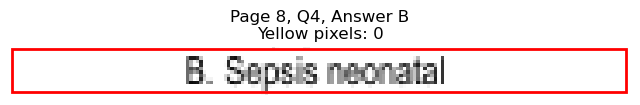

Page 8, Q4 - C: Detected box: x0=315.4, y0=367.1, x1=420.8, y1=379.8
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 662
Page 8, Q4, C: Yellow percentage: 0.0%


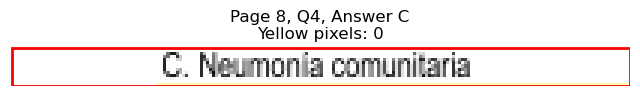

Page 8, Q4 - D: Detected box: x0=315.4, y0=379.7, x1=416.3, y1=392.4
Page 8, Q4, D: Yellow pixels: 1443
Page 8, Q4, D: Total non-white pixels: 2154
Page 8, Q4, D: Yellow percentage: 67.0%


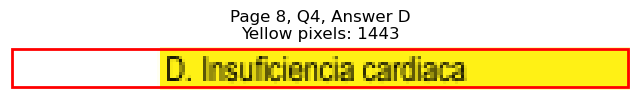


Page 8, Q4 - Selected Answer: D (based on yellow pixel count)
Page 8, Q5 - A: Detected box: x0=56.6, y0=417.6, x1=106.5, y1=430.3
Page 8, Q5, A: Yellow pixels: 102
Page 8, Q5, A: Total non-white pixels: 338
Page 8, Q5, A: Yellow percentage: 30.2%


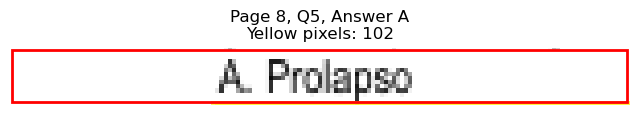

Page 8, Q5 - B: Detected box: x0=56.6, y0=430.2, x1=105.9, y1=442.9
Page 8, Q5, B: Yellow pixels: 1135
Page 8, Q5, B: Total non-white pixels: 1313
Page 8, Q5, B: Yellow percentage: 86.4%


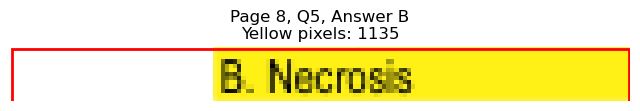

Page 8, Q5 - C: Detected box: x0=315.4, y0=417.6, x1=408.8, y1=430.3
Page 8, Q5, C: Yellow pixels: 16
Page 8, Q5, C: Total non-white pixels: 469
Page 8, Q5, C: Yellow percentage: 3.4%


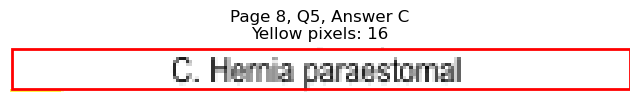

Page 8, Q5 - D: Detected box: x0=315.4, y0=430.2, x1=373.1, y1=442.9
Page 8, Q5, D: Yellow pixels: 208
Page 8, Q5, D: Total non-white pixels: 496
Page 8, Q5, D: Yellow percentage: 41.9%


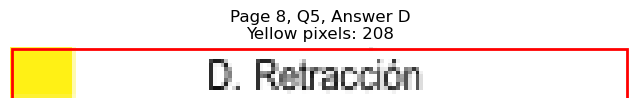


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)
Page 8, Q6 - A: Detected box: x0=56.6, y0=518.6, x1=93.9, y1=531.2
Page 8, Q6, A: Yellow pixels: 89
Page 8, Q6, A: Total non-white pixels: 233
Page 8, Q6, A: Yellow percentage: 38.2%


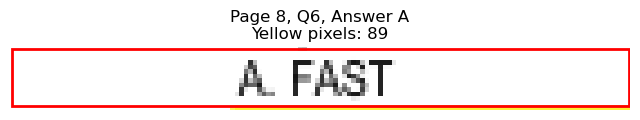

Page 8, Q6 - B: Detected box: x0=56.6, y0=531.2, x1=210.8, y1=543.8
Page 8, Q6, B: Yellow pixels: 2080
Page 8, Q6, B: Total non-white pixels: 2678
Page 8, Q6, B: Yellow percentage: 77.7%


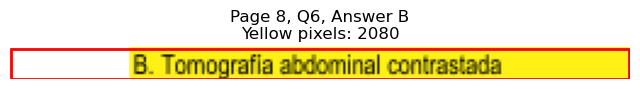

Page 8, Q6 - C: Detected box: x0=315.4, y0=518.6, x1=429.4, y1=531.2
Page 8, Q6, C: Yellow pixels: 16
Page 8, Q6, C: Total non-white pixels: 590
Page 8, Q6, C: Yellow percentage: 2.7%


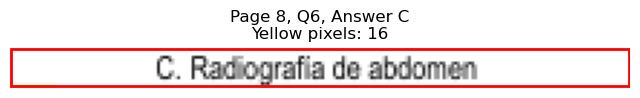

Page 8, Q6 - D: Detected box: x0=315.4, y0=531.2, x1=412.9, y1=543.8
Page 8, Q6, D: Yellow pixels: 208
Page 8, Q6, D: Total non-white pixels: 705
Page 8, Q6, D: Yellow percentage: 29.5%


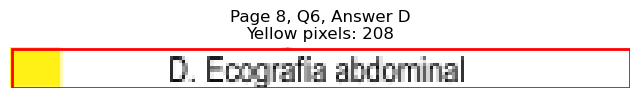


Page 8, Q6 - Selected Answer: B (based on yellow pixel count)
Page 8, Q7 - A: Detected box: x0=56.6, y0=581.7, x1=80.9, y1=594.3
Page 8, Q7, A: Yellow pixels: 76
Page 8, Q7, A: Total non-white pixels: 162
Page 8, Q7, A: Yellow percentage: 46.9%


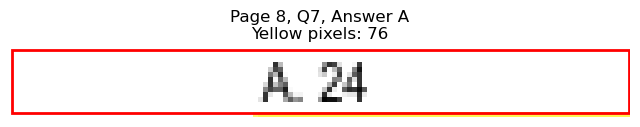

Page 8, Q7 - B: Detected box: x0=56.6, y0=594.3, x1=80.9, y1=606.9
Page 8, Q7, B: Yellow pixels: 906
Page 8, Q7, B: Total non-white pixels: 988
Page 8, Q7, B: Yellow percentage: 91.7%


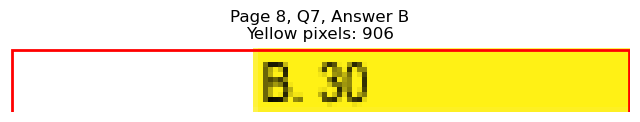

Page 8, Q7 - C: Detected box: x0=315.4, y0=581.7, x1=340.1, y1=594.3
Page 8, Q7, C: Yellow pixels: 16
Page 8, Q7, C: Total non-white pixels: 99
Page 8, Q7, C: Yellow percentage: 16.2%


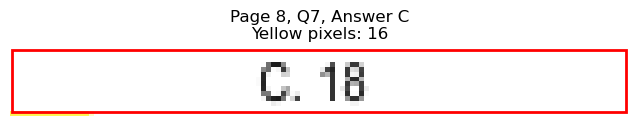

Page 8, Q7 - D: Detected box: x0=315.4, y0=594.3, x1=340.1, y1=606.9
Page 8, Q7, D: Yellow pixels: 208
Page 8, Q7, D: Total non-white pixels: 300
Page 8, Q7, D: Yellow percentage: 69.3%


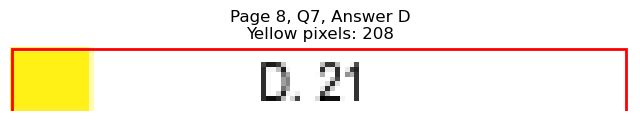


Page 8, Q7 - Selected Answer: B (based on yellow pixel count)
Page 8, Q8 - A: Detected box: x0=56.6, y0=644.8, x1=136.0, y1=657.5
Page 8, Q8, A: Yellow pixels: 131
Page 8, Q8, A: Total non-white pixels: 502
Page 8, Q8, A: Yellow percentage: 26.1%


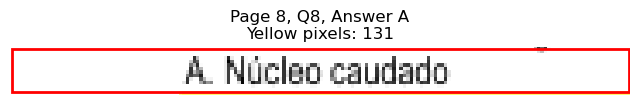

Page 8, Q8 - B: Detected box: x0=56.6, y0=657.4, x1=140.1, y1=670.1
Page 8, Q8, B: Yellow pixels: 1450
Page 8, Q8, B: Total non-white pixels: 1904
Page 8, Q8, B: Yellow percentage: 76.2%


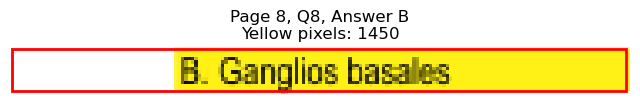

Page 8, Q8 - C: Detected box: x0=315.4, y0=644.8, x1=389.3, y1=657.5
Page 8, Q8, C: Yellow pixels: 16
Page 8, Q8, C: Total non-white pixels: 363
Page 8, Q8, C: Yellow percentage: 4.4%


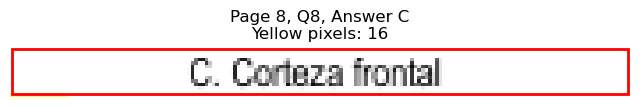

Page 8, Q8 - D: Detected box: x0=315.4, y0=657.4, x1=393.8, y1=670.1
Page 8, Q8, D: Yellow pixels: 208
Page 8, Q8, D: Total non-white pixels: 629
Page 8, Q8, D: Yellow percentage: 33.1%


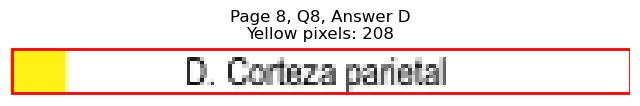


Page 8, Q8 - Selected Answer: B (based on yellow pixel count)
Page 8, Q9 - A: Detected box: x0=56.6, y0=695.4, x1=145.6, y1=708.0
Page 8, Q9, A: Yellow pixels: 1445
Page 8, Q9, A: Total non-white pixels: 1836
Page 8, Q9, A: Yellow percentage: 78.7%


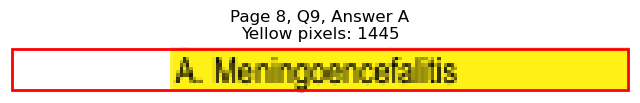

Page 8, Q9 - B: Detected box: x0=56.6, y0=708.0, x1=119.4, y1=720.6
Page 8, Q9, B: Yellow pixels: 111
Page 8, Q9, B: Total non-white pixels: 430
Page 8, Q9, B: Yellow percentage: 25.8%


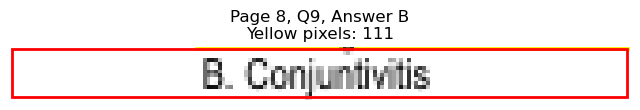

Page 8, Q9 - C: Detected box: x0=315.4, y0=695.4, x1=397.3, y1=708.0
Page 8, Q9, C: Yellow pixels: 208
Page 8, Q9, C: Total non-white pixels: 609
Page 8, Q9, C: Yellow percentage: 34.2%


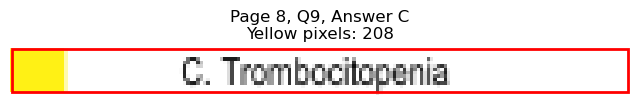

Page 8, Q9 - D: Detected box: x0=315.4, y0=708.0, x1=377.2, y1=720.6
Page 8, Q9, D: Yellow pixels: 16
Page 8, Q9, D: Total non-white pixels: 316
Page 8, Q9, D: Yellow percentage: 5.1%


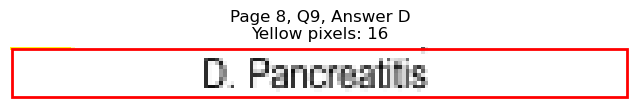


Page 8, Q9 - Selected Answer: A (based on yellow pixel count)

Page 9: Found 9 questions
Page 9, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=153.6, y1=127.3
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 480
Page 9, Q1, A: Yellow percentage: 0.0%


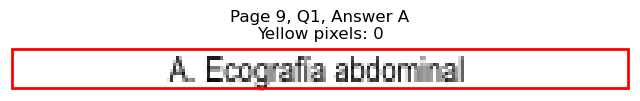

Page 9, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=180.6, y1=139.9
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 555
Page 9, Q1, B: Yellow percentage: 0.0%


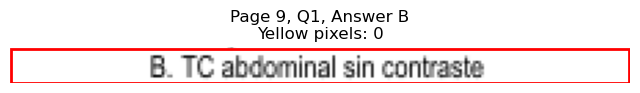

Page 9, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=422.3, y1=127.3
Page 9, Q1, C: Yellow pixels: 159
Page 9, Q1, C: Total non-white pixels: 669
Page 9, Q1, C: Yellow percentage: 23.8%


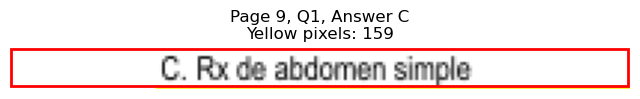

Page 9, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=422.3, y1=139.9
Page 9, Q1, D: Yellow pixels: 1653
Page 9, Q1, D: Total non-white pixels: 2080
Page 9, Q1, D: Yellow percentage: 79.5%


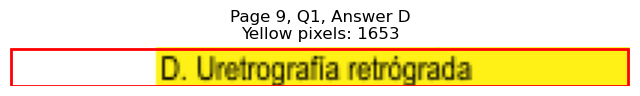


Page 9, Q1 - Selected Answer: D (based on yellow pixel count)
Page 9, Q2 - A: Detected box: x0=56.6, y0=202.9, x1=123.0, y1=215.6
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 276
Page 9, Q2, A: Yellow percentage: 0.0%


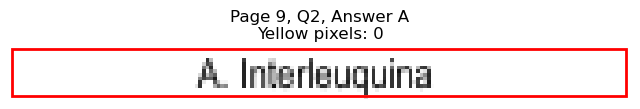

Page 9, Q2 - B: Detected box: x0=56.6, y0=215.6, x1=131.5, y1=228.3
Page 9, Q2, B: Yellow pixels: 1233
Page 9, Q2, B: Total non-white pixels: 1778
Page 9, Q2, B: Yellow percentage: 69.3%


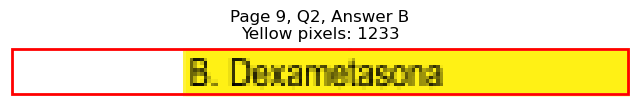

Page 9, Q2 - C: Detected box: x0=315.4, y0=202.9, x1=375.7, y1=215.6
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 289
Page 9, Q2, C: Yellow percentage: 0.0%


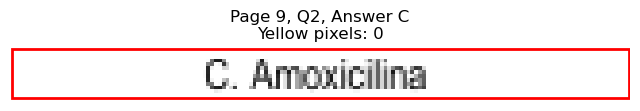

Page 9, Q2 - D: Detected box: x0=315.4, y0=215.6, x1=376.7, y1=228.3
Page 9, Q2, D: Yellow pixels: 192
Page 9, Q2, D: Total non-white pixels: 531
Page 9, Q2, D: Yellow percentage: 36.2%


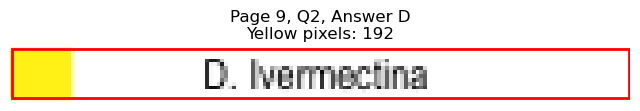


Page 9, Q2 - Selected Answer: B (based on yellow pixel count)
Page 9, Q3 - A: Detected box: x0=56.6, y0=278.8, x1=115.0, y1=291.4
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 239
Page 9, Q3, A: Yellow percentage: 0.0%


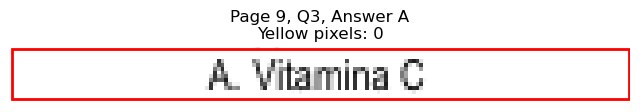

Page 9, Q3 - B: Detected box: x0=56.6, y0=291.4, x1=127.9, y1=304.0
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 330
Page 9, Q3, B: Yellow percentage: 0.0%


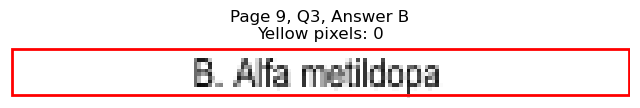

Page 9, Q3 - C: Detected box: x0=315.4, y0=278.8, x1=412.7, y1=291.4
Page 9, Q3, C: Yellow pixels: 1597
Page 9, Q3, C: Total non-white pixels: 2102
Page 9, Q3, C: Yellow percentage: 76.0%


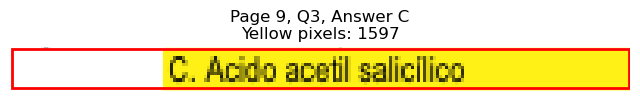

Page 9, Q3 - D: Detected box: x0=315.4, y0=291.4, x1=370.1, y1=304.0
Page 9, Q3, D: Yellow pixels: 107
Page 9, Q3, D: Total non-white pixels: 383
Page 9, Q3, D: Yellow percentage: 27.9%


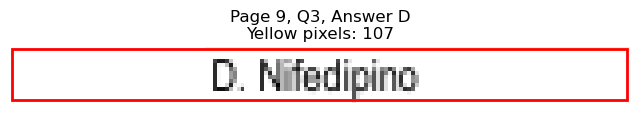


Page 9, Q3 - Selected Answer: C (based on yellow pixel count)
Page 9, Q4 - A: Detected box: x0=56.6, y0=354.5, x1=101.9, y1=367.2
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 192
Page 9, Q4, A: Yellow percentage: 0.0%


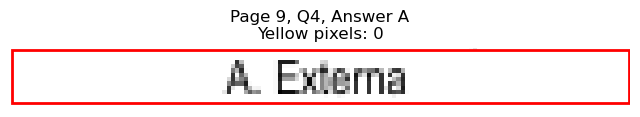

Page 9, Q4 - B: Detected box: x0=56.6, y0=367.1, x1=127.0, y1=379.8
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 357
Page 9, Q4, B: Yellow percentage: 0.0%


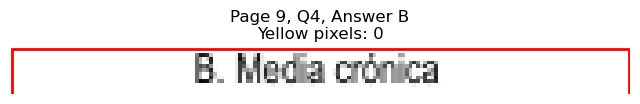

Page 9, Q4 - C: Detected box: x0=315.4, y0=354.5, x1=358.1, y1=367.2
Page 9, Q4, C: Yellow pixels: 95
Page 9, Q4, C: Total non-white pixels: 292
Page 9, Q4, C: Yellow percentage: 32.5%


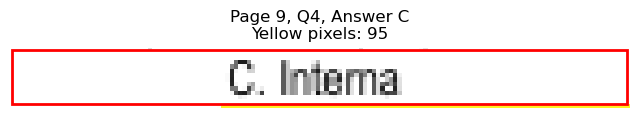

Page 9, Q4 - D: Detected box: x0=315.4, y0=367.1, x1=382.3, y1=379.8
Page 9, Q4, D: Yellow pixels: 1295
Page 9, Q4, D: Total non-white pixels: 1560
Page 9, Q4, D: Yellow percentage: 83.0%


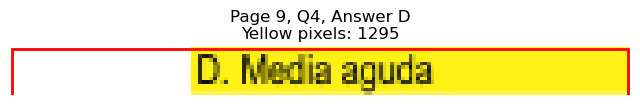


Page 9, Q4 - Selected Answer: D (based on yellow pixel count)
Page 9, Q5 - A: Detected box: x0=56.6, y0=417.6, x1=83.4, y1=430.3
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 104
Page 9, Q5, A: Yellow percentage: 0.0%


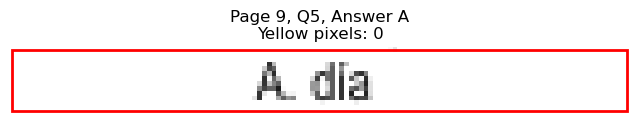

Page 9, Q5 - B: Detected box: x0=56.6, y0=430.2, x1=124.9, y1=442.9
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 315
Page 9, Q5, B: Yellow percentage: 0.0%


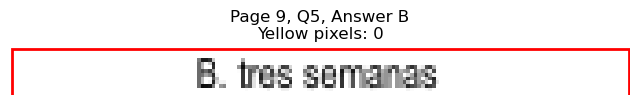

Page 9, Q5 - C: Detected box: x0=315.4, y0=417.6, x1=362.1, y1=430.3
Page 9, Q5, C: Yellow pixels: 1032
Page 9, Q5, C: Total non-white pixels: 1399
Page 9, Q5, C: Yellow percentage: 73.8%


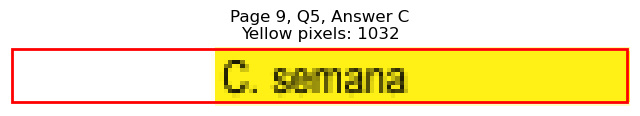

Page 9, Q5 - D: Detected box: x0=315.4, y0=430.2, x1=394.3, y1=442.9
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 496
Page 9, Q5, D: Yellow percentage: 0.0%


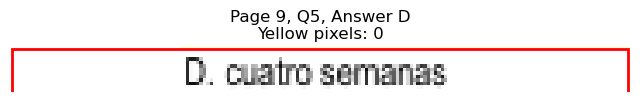


Page 9, Q5 - Selected Answer: C (based on yellow pixel count)
Page 9, Q6 - A: Detected box: x0=56.6, y0=114.6, x1=153.6, y1=127.3
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 480
Page 9, Q6, A: Yellow percentage: 0.0%


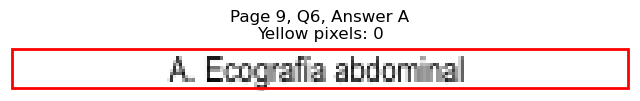

Page 9, Q6 - B: Detected box: x0=56.6, y0=506.0, x1=134.5, y1=518.6
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 355
Page 9, Q6, B: Yellow percentage: 0.0%


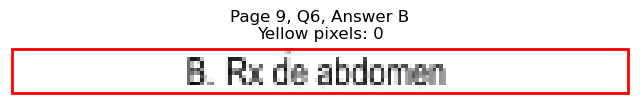

Page 9, Q6 - C: Detected box: x0=315.4, y0=493.4, x1=356.7, y1=506.0
Page 9, Q6, C: Yellow pixels: 1085
Page 9, Q6, C: Total non-white pixels: 1223
Page 9, Q6, C: Yellow percentage: 88.7%


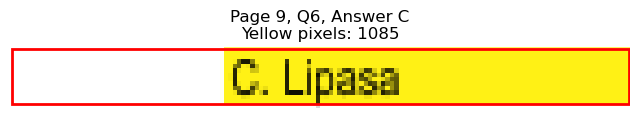

Page 9, Q6 - D: Detected box: x0=315.4, y0=506.0, x1=362.1, y1=518.6
Page 9, Q6, D: Yellow pixels: 98
Page 9, Q6, D: Total non-white pixels: 317
Page 9, Q6, D: Yellow percentage: 30.9%


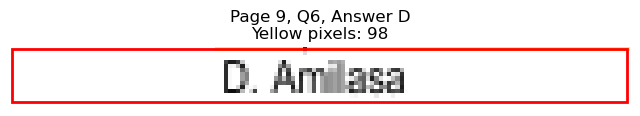


Page 9, Q6 - Selected Answer: C (based on yellow pixel count)
Page 9, Q7 - A: Detected box: x0=56.6, y0=556.5, x1=143.5, y1=569.1
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 404
Page 9, Q7, A: Yellow percentage: 0.0%


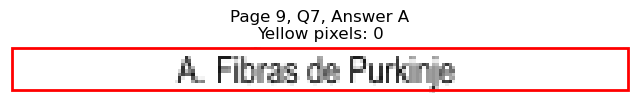

Page 9, Q7 - B: Detected box: x0=56.6, y0=569.1, x1=115.0, y1=581.7
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 267
Page 9, Q7, B: Yellow percentage: 0.0%


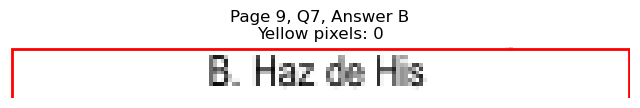

Page 9, Q7 - C: Detected box: x0=315.4, y0=556.5, x1=383.2, y1=569.1
Page 9, Q7, C: Yellow pixels: 120
Page 9, Q7, C: Total non-white pixels: 447
Page 9, Q7, C: Yellow percentage: 26.8%


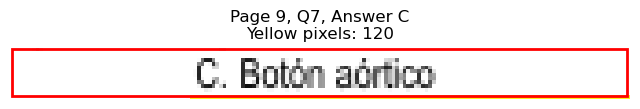

Page 9, Q7 - D: Detected box: x0=315.4, y0=569.1, x1=438.9, y1=581.7
Page 9, Q7, D: Yellow pixels: 1818
Page 9, Q7, D: Total non-white pixels: 2288
Page 9, Q7, D: Yellow percentage: 79.5%


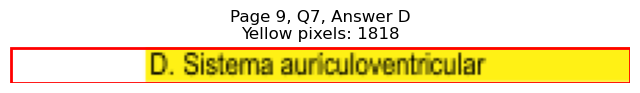


Page 9, Q7 - Selected Answer: D (based on yellow pixel count)
Page 9, Q8 - A: Detected box: x0=56.6, y0=632.2, x1=154.6, y1=644.9
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 457
Page 9, Q8, A: Yellow percentage: 0.0%


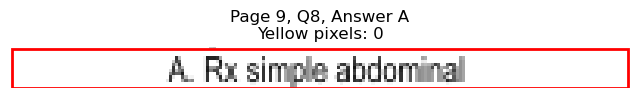

Page 9, Q8 - B: Detected box: x0=56.6, y0=644.8, x1=175.6, y1=657.5
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 567
Page 9, Q8, B: Yellow percentage: 0.0%


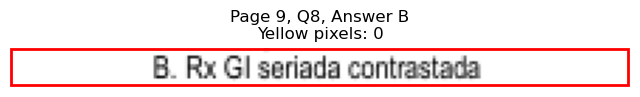

Page 9, Q8 - C: Detected box: x0=315.4, y0=632.2, x1=412.9, y1=644.9
Page 9, Q8, C: Yellow pixels: 1570
Page 9, Q8, C: Total non-white pixels: 1950
Page 9, Q8, C: Yellow percentage: 80.5%


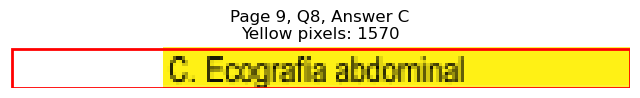

Page 9, Q8 - D: Detected box: x0=315.4, y0=644.8, x1=420.3, y1=657.5
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 524
Page 9, Q8, D: Yellow percentage: 0.0%


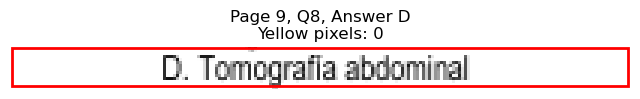


Page 9, Q8 - Selected Answer: C (based on yellow pixel count)
Page 9, Q9 - A: Detected box: x0=56.6, y0=708.0, x1=156.6, y1=720.6
Page 9, Q9, A: Yellow pixels: 151
Page 9, Q9, A: Total non-white pixels: 624
Page 9, Q9, A: Yellow percentage: 24.2%


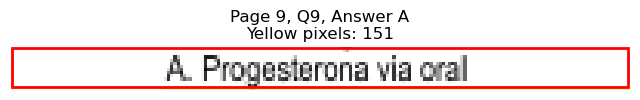

Page 9, Q9 - B: Detected box: x0=56.6, y0=720.6, x1=136.9, y1=733.2
Page 9, Q9, B: Yellow pixels: 1422
Page 9, Q9, B: Total non-white pixels: 1848
Page 9, Q9, B: Yellow percentage: 76.9%


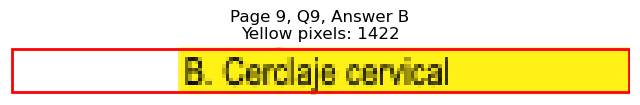

Page 9, Q9 - C: Detected box: x0=315.4, y0=708.0, x1=416.8, y1=720.6
Page 9, Q9, C: Yellow pixels: 16
Page 9, Q9, C: Total non-white pixels: 507
Page 9, Q9, C: Yellow percentage: 3.2%


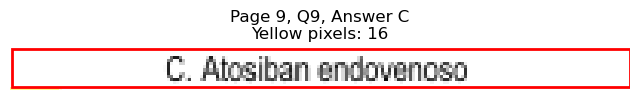

Page 9, Q9 - D: Detected box: x0=315.4, y0=720.6, x1=409.3, y1=733.2
Page 9, Q9, D: Yellow pixels: 208
Page 9, Q9, D: Total non-white pixels: 717
Page 9, Q9, D: Yellow percentage: 29.0%


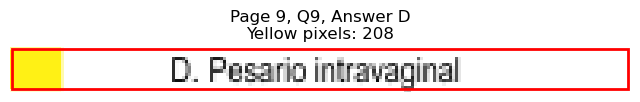


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)

Page 10: Found 10 questions
Page 10, Q1 - A: Detected box: x0=56.6, y0=127.2, x1=125.4, y1=139.9
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 309
Page 10, Q1, A: Yellow percentage: 0.0%


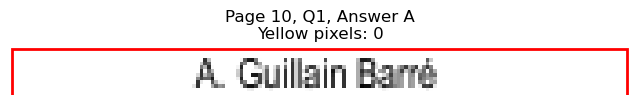

Page 10, Q1 - B: Detected box: x0=56.6, y0=139.9, x1=115.9, y1=152.6
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 283
Page 10, Q1, B: Yellow percentage: 0.0%


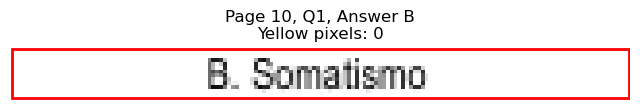

Page 10, Q1 - C: Detected box: x0=315.4, y0=127.2, x1=402.3, y1=139.9
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 452
Page 10, Q1, C: Yellow percentage: 0.0%


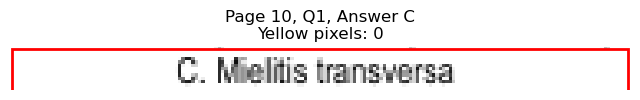

Page 10, Q1 - D: Detected box: x0=315.4, y0=139.9, x1=370.6, y1=152.6
Page 10, Q1, D: Yellow pixels: 1194
Page 10, Q1, D: Total non-white pixels: 1511
Page 10, Q1, D: Yellow percentage: 79.0%


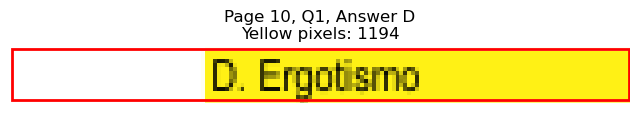


Page 10, Q1 - Selected Answer: D (based on yellow pixel count)
Page 10, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=73.3, y1=203.0
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 112
Page 10, Q2, A: Yellow percentage: 0.0%


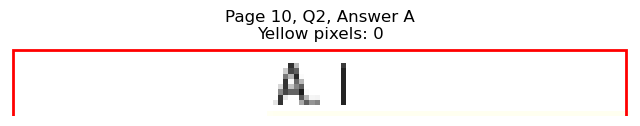

Page 10, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=75.9, y1=215.6
Page 10, Q2, B: Yellow pixels: 862
Page 10, Q2, B: Total non-white pixels: 994
Page 10, Q2, B: Yellow percentage: 86.7%


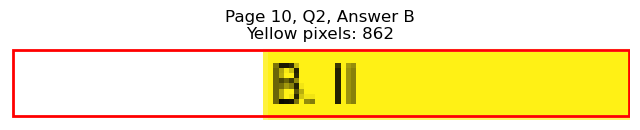

Page 10, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=337.6, y1=203.0
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 106
Page 10, Q2, C: Yellow percentage: 0.0%


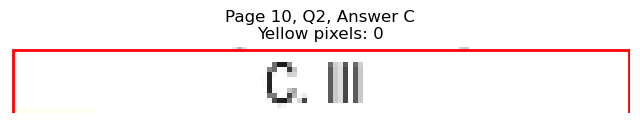

Page 10, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=338.6, y1=215.6
Page 10, Q2, D: Yellow pixels: 208
Page 10, Q2, D: Total non-white pixels: 320
Page 10, Q2, D: Yellow percentage: 65.0%


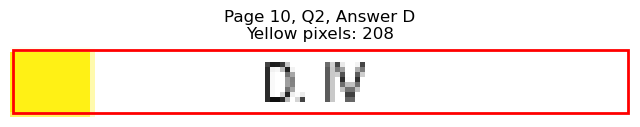


Page 10, Q2 - Selected Answer: B (based on yellow pixel count)
Page 10, Q3 - A: Detected box: x0=56.6, y0=278.8, x1=127.9, y1=291.4
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 331
Page 10, Q3, A: Yellow percentage: 0.0%


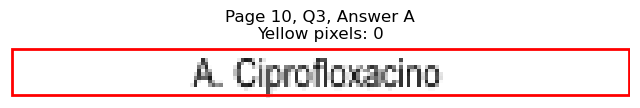

Page 10, Q3 - B: Detected box: x0=56.6, y0=291.4, x1=123.5, y1=304.0
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 323
Page 10, Q3, B: Yellow percentage: 0.0%


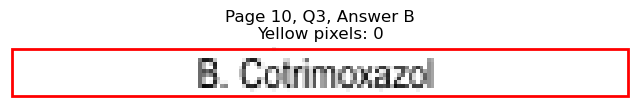

Page 10, Q3 - C: Detected box: x0=315.4, y0=278.8, x1=385.3, y1=291.4
Page 10, Q3, C: Yellow pixels: 122
Page 10, Q3, C: Total non-white pixels: 433
Page 10, Q3, C: Yellow percentage: 28.2%


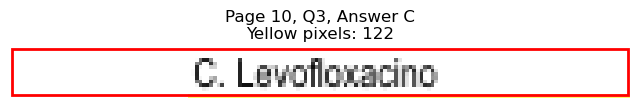

Page 10, Q3 - D: Detected box: x0=315.4, y0=291.4, x1=381.7, y1=304.0
Page 10, Q3, D: Yellow pixels: 1310
Page 10, Q3, D: Total non-white pixels: 1665
Page 10, Q3, D: Yellow percentage: 78.7%


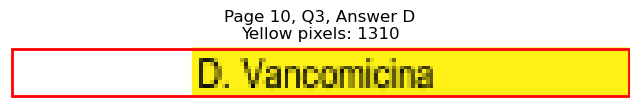


Page 10, Q3 - Selected Answer: D (based on yellow pixel count)
Page 10, Q4 - A: Detected box: x0=56.6, y0=341.9, x1=75.9, y1=354.6
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 59
Page 10, Q4, A: Yellow percentage: 0.0%


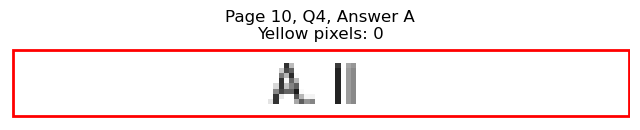

Page 10, Q4 - B: Detected box: x0=56.6, y0=354.5, x1=79.3, y1=367.2
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 78
Page 10, Q4, B: Yellow percentage: 0.0%


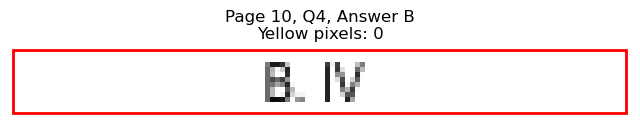

Page 10, Q4 - C: Detected box: x0=315.4, y0=341.9, x1=336.1, y1=354.6
Page 10, Q4, C: Yellow pixels: 902
Page 10, Q4, C: Total non-white pixels: 1035
Page 10, Q4, C: Yellow percentage: 87.1%


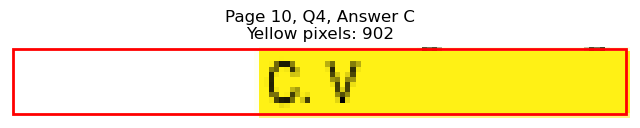

Page 10, Q4 - D: Detected box: x0=315.4, y0=354.5, x1=337.6, y1=367.2
Page 10, Q4, D: Yellow pixels: 74
Page 10, Q4, D: Total non-white pixels: 163
Page 10, Q4, D: Yellow percentage: 45.4%


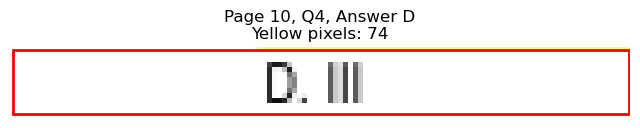


Page 10, Q4 - Selected Answer: C (based on yellow pixel count)
Page 10, Q5 - A: Detected box: x0=56.6, y0=404.9, x1=100.9, y1=417.6
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 195
Page 10, Q5, A: Yellow percentage: 0.0%


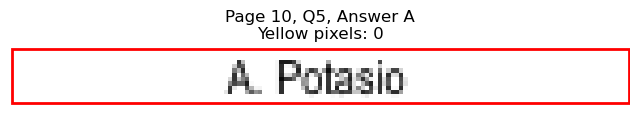

Page 10, Q5 - B: Detected box: x0=56.6, y0=417.6, x1=115.5, y1=430.3
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 271
Page 10, Q5, B: Yellow percentage: 0.0%


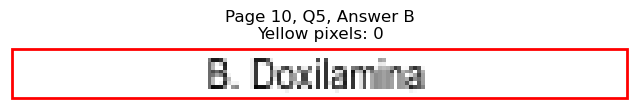

Page 10, Q5 - C: Detected box: x0=315.4, y0=404.9, x1=373.7, y1=417.6
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 258
Page 10, Q5, C: Yellow percentage: 0.0%


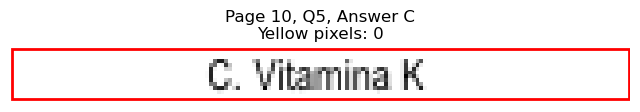

Page 10, Q5 - D: Detected box: x0=315.4, y0=417.6, x1=362.1, y1=430.3
Page 10, Q5, D: Yellow pixels: 1033
Page 10, Q5, D: Total non-white pixels: 1399
Page 10, Q5, D: Yellow percentage: 73.8%


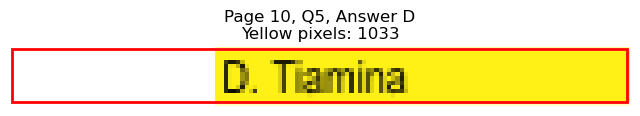


Page 10, Q5 - Selected Answer: D (based on yellow pixel count)
Page 10, Q6 - A: Detected box: x0=56.6, y0=493.4, x1=189.6, y1=506.0
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 623
Page 10, Q6, A: Yellow percentage: 0.0%


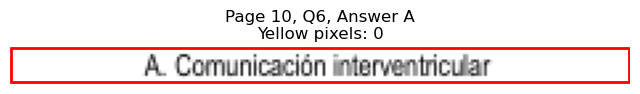

Page 10, Q6 - B: Detected box: x0=56.6, y0=506.0, x1=150.0, y1=518.6
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 447
Page 10, Q6, B: Yellow percentage: 0.0%


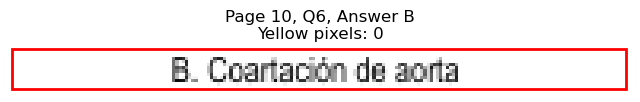

Page 10, Q6 - C: Detected box: x0=315.4, y0=493.4, x1=441.9, y1=506.0
Page 10, Q6, C: Yellow pixels: 1870
Page 10, Q6, C: Total non-white pixels: 2327
Page 10, Q6, C: Yellow percentage: 80.4%


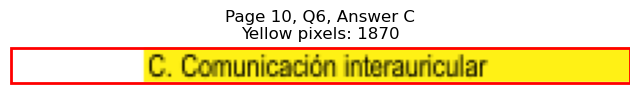

Page 10, Q6 - D: Detected box: x0=315.4, y0=506.0, x1=395.7, y1=518.6
Page 10, Q6, D: Yellow pixels: 132
Page 10, Q6, D: Total non-white pixels: 515
Page 10, Q6, D: Yellow percentage: 25.6%


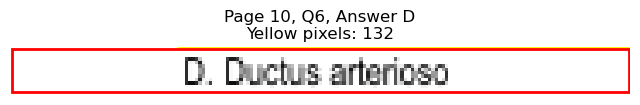


Page 10, Q6 - Selected Answer: C (based on yellow pixel count)
Page 10, Q7 - A: Detected box: x0=56.6, y0=569.1, x1=85.8, y1=581.7
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 121
Page 10, Q7, A: Yellow percentage: 0.0%


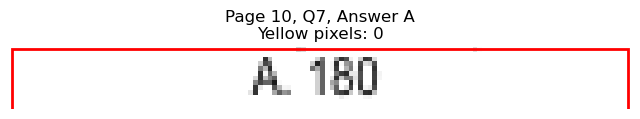

Page 10, Q7 - B: Detected box: x0=56.6, y0=581.7, x1=85.8, y1=594.3
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 123
Page 10, Q7, B: Yellow percentage: 0.0%


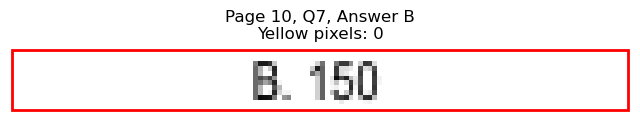

Page 10, Q7 - C: Detected box: x0=315.4, y0=569.1, x1=345.1, y1=581.7
Page 10, Q7, C: Yellow pixels: 985
Page 10, Q7, C: Total non-white pixels: 1081
Page 10, Q7, C: Yellow percentage: 91.1%


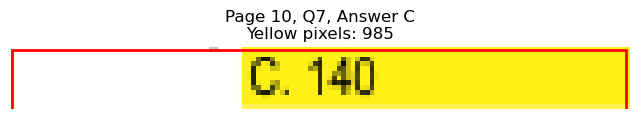

Page 10, Q7 - D: Detected box: x0=315.4, y0=581.7, x1=345.1, y1=594.3
Page 10, Q7, D: Yellow pixels: 82
Page 10, Q7, D: Total non-white pixels: 203
Page 10, Q7, D: Yellow percentage: 40.4%


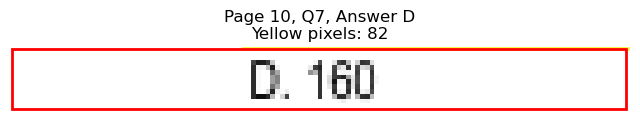


Page 10, Q7 - Selected Answer: C (based on yellow pixel count)
Page 10, Q8 - A: Detected box: x0=56.6, y0=632.2, x1=118.0, y1=644.9
Page 10, Q8, A: Yellow pixels: 0
Page 10, Q8, A: Total non-white pixels: 383
Page 10, Q8, A: Yellow percentage: 0.0%


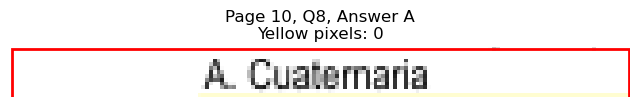

Page 10, Q8 - B: Detected box: x0=56.6, y0=644.8, x1=116.4, y1=657.5
Page 10, Q8, B: Yellow pixels: 1202
Page 10, Q8, B: Total non-white pixels: 1568
Page 10, Q8, B: Yellow percentage: 76.7%


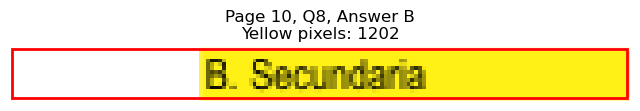

Page 10, Q8 - C: Detected box: x0=315.4, y0=632.2, x1=363.7, y1=644.9
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 222
Page 10, Q8, C: Yellow percentage: 0.0%


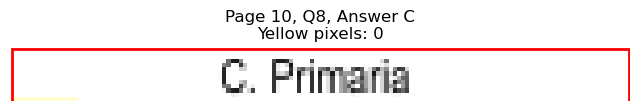

Page 10, Q8 - D: Detected box: x0=315.4, y0=644.8, x1=365.1, y1=657.5
Page 10, Q8, D: Yellow pixels: 208
Page 10, Q8, D: Total non-white pixels: 467
Page 10, Q8, D: Yellow percentage: 44.5%


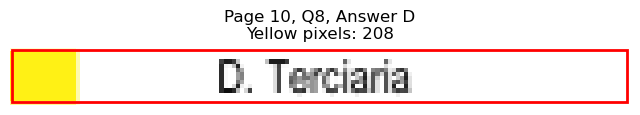


Page 10, Q8 - Selected Answer: B (based on yellow pixel count)
Page 10, Q9 - A: Detected box: x0=56.6, y0=695.4, x1=145.0, y1=708.0
Page 10, Q9, A: Yellow pixels: 140
Page 10, Q9, A: Total non-white pixels: 703
Page 10, Q9, A: Yellow percentage: 19.9%


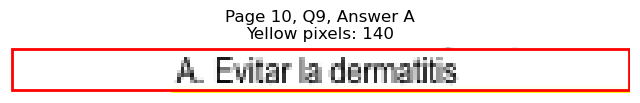

Page 10, Q9 - B: Detected box: x0=56.6, y0=708.0, x1=148.0, y1=720.6
Page 10, Q9, B: Yellow pixels: 1536
Page 10, Q9, B: Total non-white pixels: 2002
Page 10, Q9, B: Yellow percentage: 76.7%


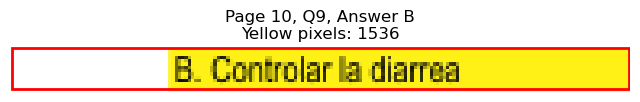

Page 10, Q9 - C: Detected box: x0=315.4, y0=695.4, x1=440.8, y1=708.0
Page 10, Q9, C: Yellow pixels: 16
Page 10, Q9, C: Total non-white pixels: 658
Page 10, Q9, C: Yellow percentage: 2.4%


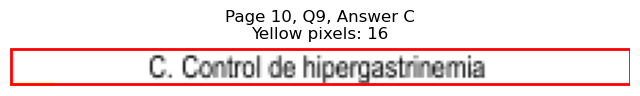

Page 10, Q9 - D: Detected box: x0=315.4, y0=708.0, x1=447.9, y1=720.6
Page 10, Q9, D: Yellow pixels: 208
Page 10, Q9, D: Total non-white pixels: 888
Page 10, Q9, D: Yellow percentage: 23.4%


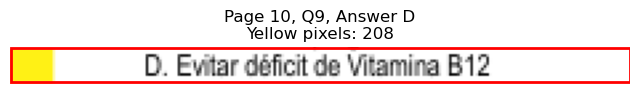


Page 10, Q9 - Selected Answer: B (based on yellow pixel count)
Page 10, Q10 - A: Detected box: x0=56.6, y0=745.8, x1=80.2, y1=758.4
Page 10, Q10, A: Yellow pixels: 931
Page 10, Q10, A: Total non-white pixels: 1064
Page 10, Q10, A: Yellow percentage: 87.5%


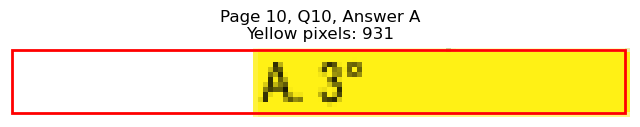

Page 10, Q10 - B: Detected box: x0=56.6, y0=758.5, x1=80.2, y1=771.1
Page 10, Q10, B: Yellow pixels: 75
Page 10, Q10, B: Total non-white pixels: 144
Page 10, Q10, B: Yellow percentage: 52.1%


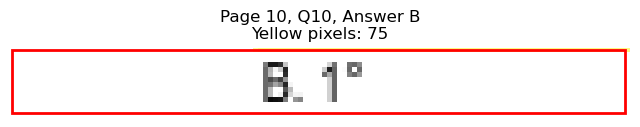

Page 10, Q10 - C: Detected box: x0=315.4, y0=745.8, x1=339.4, y1=758.4
Page 10, Q10, C: Yellow pixels: 208
Page 10, Q10, C: Total non-white pixels: 314
Page 10, Q10, C: Yellow percentage: 66.2%


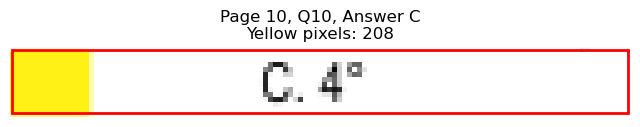


Page 10, Q10 - Selected Answer: A (based on yellow pixel count)

Page 11: Found 6 questions
Page 11, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=133.0, y1=114.7
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 377
Page 11, Q1, A: Yellow percentage: 0.0%


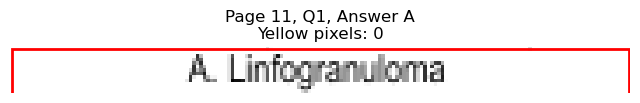

Page 11, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=104.9, y1=127.3
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 220
Page 11, Q1, B: Yellow percentage: 0.0%


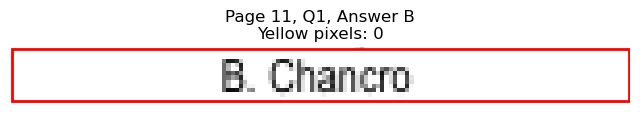

Page 11, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=374.7, y1=114.7
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 377
Page 11, Q1, C: Yellow percentage: 0.0%


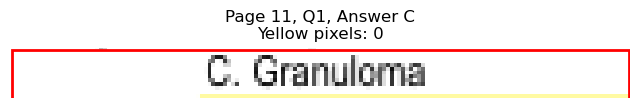

Page 11, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=376.1, y1=127.3
Page 11, Q1, D: Yellow pixels: 1130
Page 11, Q1, D: Total non-white pixels: 1595
Page 11, Q1, D: Yellow percentage: 70.8%


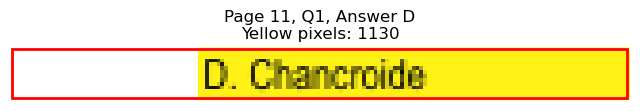


Page 11, Q1 - Selected Answer: D (based on yellow pixel count)
Page 11, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=109.5, y1=177.8
Page 11, Q2, A: Yellow pixels: 0
Page 11, Q2, A: Total non-white pixels: 235
Page 11, Q2, A: Yellow percentage: 0.0%


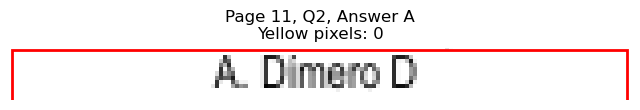

Page 11, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=213.3, y1=190.4
Page 11, Q2, B: Yellow pixels: 0
Page 11, Q2, B: Total non-white pixels: 742
Page 11, Q2, B: Yellow percentage: 0.0%


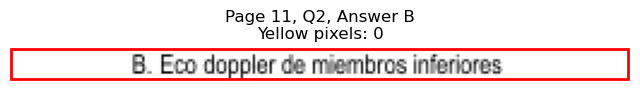

Page 11, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=425.3, y1=177.8
Page 11, Q2, C: Yellow pixels: 1
Page 11, Q2, C: Total non-white pixels: 696
Page 11, Q2, C: Yellow percentage: 0.1%


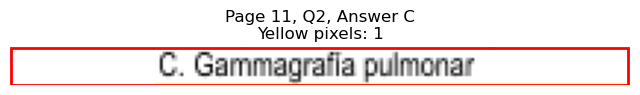

Page 11, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=436.4, y1=190.4
Page 11, Q2, D: Yellow pixels: 1609
Page 11, Q2, D: Total non-white pixels: 2435
Page 11, Q2, D: Yellow percentage: 66.1%


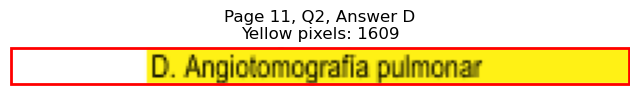


Page 11, Q2 - Selected Answer: D (based on yellow pixel count)
Page 11, Q3 - A: Detected box: x0=56.6, y0=228.2, x1=119.9, y1=240.9
Page 11, Q3, A: Yellow pixels: 0
Page 11, Q3, A: Total non-white pixels: 410
Page 11, Q3, A: Yellow percentage: 0.0%


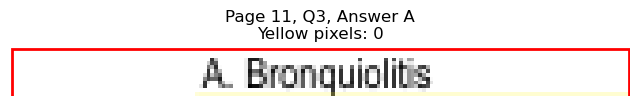

Page 11, Q3 - B: Detected box: x0=56.6, y0=240.8, x1=185.7, y1=253.5
Page 11, Q3, B: Yellow pixels: 1885
Page 11, Q3, B: Total non-white pixels: 2534
Page 11, Q3, B: Yellow percentage: 74.4%


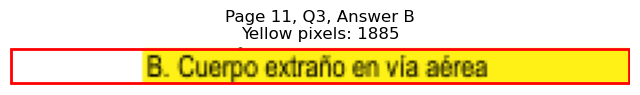

Page 11, Q3 - C: Detected box: x0=315.4, y0=228.2, x1=391.3, y1=240.9
Page 11, Q3, C: Yellow pixels: 0
Page 11, Q3, C: Total non-white pixels: 390
Page 11, Q3, C: Yellow percentage: 0.0%


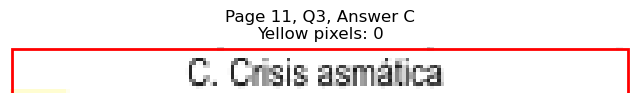

Page 11, Q3 - D: Detected box: x0=315.4, y0=240.8, x1=424.9, y1=253.5
Page 11, Q3, D: Yellow pixels: 208
Page 11, Q3, D: Total non-white pixels: 768
Page 11, Q3, D: Yellow percentage: 27.1%


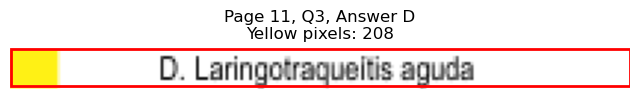


Page 11, Q3 - Selected Answer: B (based on yellow pixel count)
Page 11, Q4 - A: Detected box: x0=56.6, y0=291.4, x1=152.5, y1=304.0
Page 11, Q4, A: Yellow pixels: 0
Page 11, Q4, A: Total non-white pixels: 484
Page 11, Q4, A: Yellow percentage: 0.0%


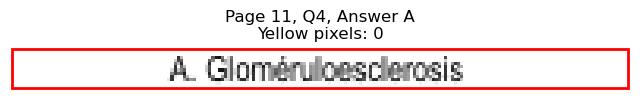

Page 11, Q4 - B: Detected box: x0=56.6, y0=304.0, x1=139.0, y1=316.6
Page 11, Q4, B: Yellow pixels: 0
Page 11, Q4, B: Total non-white pixels: 419
Page 11, Q4, B: Yellow percentage: 0.0%


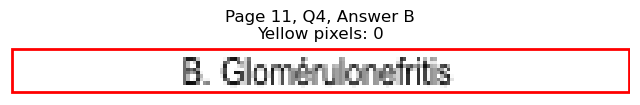

Page 11, Q4 - C: Detected box: x0=315.4, y0=291.4, x1=452.9, y1=304.0
Page 11, Q4, C: Yellow pixels: 1914
Page 11, Q4, C: Total non-white pixels: 2662
Page 11, Q4, C: Yellow percentage: 71.9%


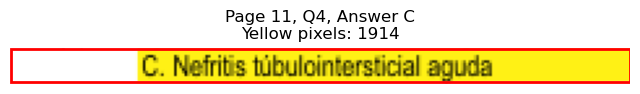

Page 11, Q4 - D: Detected box: x0=315.4, y0=304.0, x1=409.3, y1=316.6
Page 11, Q4, D: Yellow pixels: 142
Page 11, Q4, D: Total non-white pixels: 757
Page 11, Q4, D: Yellow percentage: 18.8%


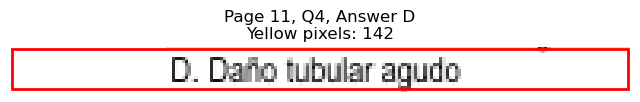


Page 11, Q4 - Selected Answer: C (based on yellow pixel count)
Page 11, Q5 - A: Detected box: x0=56.6, y0=354.5, x1=111.4, y1=367.2
Page 11, Q5, A: Yellow pixels: 0
Page 11, Q5, A: Total non-white pixels: 294
Page 11, Q5, A: Yellow percentage: 0.0%


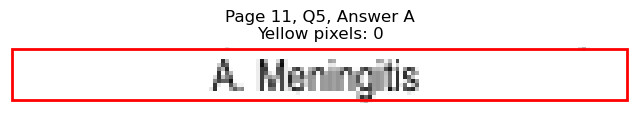

Page 11, Q5 - B: Detected box: x0=56.6, y0=367.1, x1=167.5, y1=379.8
Page 11, Q5, B: Yellow pixels: 0
Page 11, Q5, B: Total non-white pixels: 539
Page 11, Q5, B: Yellow percentage: 0.0%


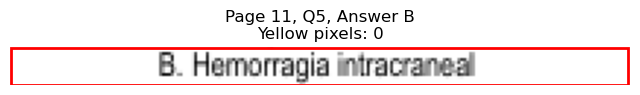

Page 11, Q5 - C: Detected box: x0=315.4, y0=354.5, x1=400.3, y1=367.2
Page 11, Q5, C: Yellow pixels: 137
Page 11, Q5, C: Total non-white pixels: 549
Page 11, Q5, C: Yellow percentage: 25.0%


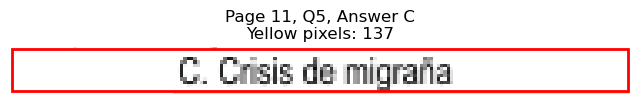

Page 11, Q5 - D: Detected box: x0=315.4, y0=367.1, x1=405.8, y1=379.8
Page 11, Q5, D: Yellow pixels: 1509
Page 11, Q5, D: Total non-white pixels: 1859
Page 11, Q5, D: Yellow percentage: 81.2%


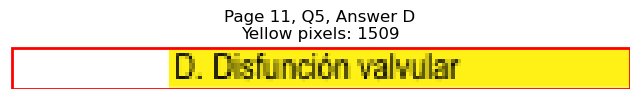


Page 11, Q5 - Selected Answer: D (based on yellow pixel count)
Page 11, Q6 - A: Detected box: x0=56.6, y0=442.8, x1=145.6, y1=455.5
Page 11, Q6, A: Yellow pixels: 1492
Page 11, Q6, A: Total non-white pixels: 1974
Page 11, Q6, A: Yellow percentage: 75.6%


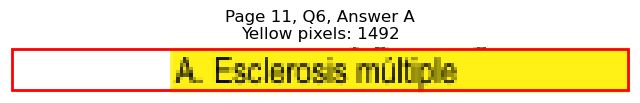

Page 11, Q6 - B: Detected box: x0=56.6, y0=455.5, x1=165.6, y1=468.1
Page 11, Q6, B: Yellow pixels: 0
Page 11, Q6, B: Total non-white pixels: 534
Page 11, Q6, B: Yellow percentage: 0.0%


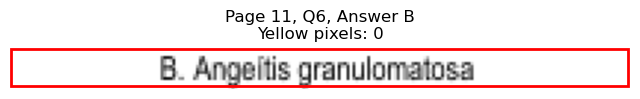

Page 11, Q6 - C: Detected box: x0=315.4, y0=442.8, x1=376.7, y1=455.5
Page 11, Q6, C: Yellow pixels: 208
Page 11, Q6, C: Total non-white pixels: 531
Page 11, Q6, C: Yellow percentage: 39.2%


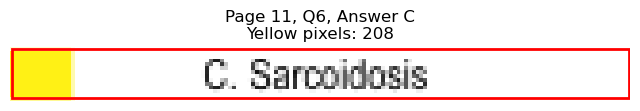

Page 11, Q6 - D: Detected box: x0=315.4, y0=455.5, x1=450.9, y1=468.1
Page 11, Q6, D: Yellow pixels: 0
Page 11, Q6, D: Total non-white pixels: 684
Page 11, Q6, D: Yellow percentage: 0.0%


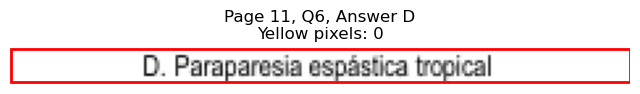


Page 11, Q6 - Selected Answer: A (based on yellow pixel count)

⚠️ The following questions were skipped due to missing options:
Page 5, Q9
Page 7, Q10
Page 10, Q10


In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Niño de 6 años, presenta hace 7 días rinorrea ...
1   Varón de 77 años, fumador, acude por presentar...
2   Mujer de 46 años, acude por dolor abdominal, n...
3   Primigesta de 38 semanas, acude por presentar ...
4   En el ámbito sanitario de una red integrada de...
..                                                ...
95  Varón de 76 años, en reposo post operatorio de...
96  Niño de 2 años previamente sano, es traído a e...
97  Mujer de 51 años, cursa con recidiva de cáncer...
98  Escolar de 12 años con derivación ventrículo p...
99  Varón de 38 años, acude por presentar parestes...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                                       Microbiología   
1                                              Normal   
2                                              Severa   
3                       Evolución espontánea de parto   
4   Implementar nuevo servicio de cuidados intensivos   
..                                                ...   
95                                           Dímero D   
96                                      Bronquiolitis   
97                                Gloméruloesclerosis   
98                                         Meningitis   
99                                Esclerosis múltiple   

                                             option_B  \
0                                          Tomografía   
1                                         Obstructivo   
2                                            Moderada   
3                            Cesárea a las 40 semanas   
4   Incrementar el requerimiento de medicamentos e...   
..                                                ...   
95                 Eco doppler de miembros inferiores   
96                        Cuerpo extraño en vía aérea   
97                                  Glomérulonefritis   
98                            Hemorragia intracraneal   
99                             Angeítis granulomatosa   

                                        option_C  \
0                                      Serología   
1                                    Restrictivo   
2                                          Grave   
3                          Terminar la gestación   
4   Solicitar contrato de personal especializado   
..                                           ...   
95                          Gammagrafía pulmonar   
96                               Crisis asmática   
97             Nefritis túbulointersticial aguda   
98                             Crisis de migraña   
99                                   Sarcoidosis   

                                             option_D  
0                                         Radiografía  
1                                               Mixto  
2                                                Leve  
3                   Control en una semana con doppler  
4   Acción intersectorial y abordaje de los determ...  
..                                                ...  
95                           Angiotomografía pulmonar  
96                            Laringotraqueítis aguda  
97                                 Daño tubular agudo  
98                                Disfunción valvular  
99                     Paraparesia espástica tropical  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               D
1               B
2               B
3               C
4               D
..            ...
95              D
96              B
97              C
98              D
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Niño de 6 años, presenta hace 7 días rinorrea ...   
1   Varón de 77 años, fumador, acude por presentar...   
2   Mujer de 46 años, acude por dolor abdominal, n...   
3   Primigesta de 38 semanas, acude por presentar ...   
4   En el ámbito sanitario de una red integrada de...   
..                                                ...   
95  Varón de 76 años, en reposo post operatorio de...   
96  Niño de 2 años previamente sano, es traído a e...   
97  Mujer de 51 años, cursa con recidiva de cáncer...   
98  Escolar de 12 años con derivación ventrículo p...   
99  Varón de 38 años, acude por presentar parestes...   

                                             option_A  \
0                                       Microbiología   
1                                              Normal   
2                                              Severa   
3                       Evolución espontánea de parto   
4   Implementar nuevo servicio de cuidados intensivos   
..                                                ...   
95                                           Dímero D   
96                                      Bronquiolitis   
97                                Gloméruloesclerosis   
98                                         Meningitis   
99                                Esclerosis múltiple   

                                             option_B  \
0                                          Tomografía   
1                                         Obstructivo   
2                                            Moderada   
3                            Cesárea a las 40 semanas   
4   Incrementar el requerimiento de medicamentos e...   
..                                                ...   
95                 Eco doppler de miembros inferiores   
96                        Cuerpo extraño en vía aérea   
97                                  Glomérulonefritis   
98                            Hemorragia intracraneal   
99                             Angeítis granulomatosa   

                                        option_C  \
0                                      Serología   
1                                    Restrictivo   
2                                          Grave   
3                          Terminar la gestación   
4   Solicitar contrato de personal especializado   
..                                           ...   
95                          Gammagrafía pulmonar   
96                               Crisis asmática   
97             Nefritis túbulointersticial aguda   
98                             Crisis de migraña   
99                                   Sarcoidosis   

                                             option_D correct_answer  
0                                         Radiografía              D  
1                                               Mixto              B  
2                                                Leve              B  
3                   Control en una semana con doppler              C  
4   Acción intersectorial y abordaje de los determ...              D  
..                                                ...            ...  
95                           Angiotomografía pulmonar              D  
96                            Laringotraqueítis aguda              B  
97                                 Daño tubular agudo              C  
98                                Disfunción valvular              D  
99                     Paraparesia espástica tropical              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/ESPECIALIADAD A.csv
